In [2]:
getDefaultColors <- function (n = NULL, type = 1) 
{
  if (type == 1) {
    colors <- c("#cb7c77", "#68d359", "#6a7dc9", "#c9d73d", 
      "#c555cb", "#d7652d", "#7cd5c8", "#c49a3f", "#507d41", 
      "#5d8d9c", "#90353b", "#674c2a", "#1B9E77", "#c5383c", 
      "#0081d1", "#ffd900", "#502e71", "#c8b693", "#aed688", 
      "#f6a97a", "#c6a5cc", "#798234", "#6b42c8", "#cf4c8b", 
      "#666666", "#feb308", "#ff1a1a", "#1aff1a", "#1a1aff", 
      "#ffff1a")
  }
  else if (type == 2) {
    if (n <= 8) {
      colors <- c("#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", 
        "#A6D854", "#FFD92F", "#E5C494", "#B3B3B3")
    }
    else if (n <= 14) {
      colors <- c("#437BFE", "#FEC643", "#43FE69", "#FE6943", 
        "#C643FE", "#43D9FE", "#B87A3D", "#679966", 
        "#993333", "#7F6699", "#E78AC3", "#333399", 
        "#A6D854", "#E5C494")
    }
    else if (n <= 20) {
      colors <- c("#87b3d4", "#d5492f", "#6bd155", "#683ec2", 
        "#c9d754", "#d04dc7", "#81d8ae", "#d34a76", 
        "#607d3a", "#6d76cb", "#ce9d3f", "#81357a", 
        "#d3c3a4", "#3c2f5a", "#b96f49", "#4e857e", 
        "#6e282c", "#d293c8", "#393a2a", "#997579")
    }
    else if (n <= 30) {
      colors <- c("#628bac", "#ceda3f", "#7e39c9", "#72d852", 
        "#d849cc", "#5e8f37", "#5956c8", "#cfa53f", 
        "#392766", "#c7da8b", "#8d378c", "#68d9a3", 
        "#dd3e34", "#8ed4d5", "#d84787", "#498770", 
        "#c581d3", "#d27333", "#6680cb", "#83662e", 
        "#cab7da", "#364627", "#d16263", "#2d384d", 
        "#e0b495", "#4b272a", "#919071", "#7b3860", 
        "#843028", "#bb7d91")
    }
    else {
      colors <- c("#982f29", "#5ddb53", "#8b35d6", "#a9e047", 
        "#4836be", "#e0dc33", "#d248d5", "#61a338", 
        "#9765e5", "#69df96", "#7f3095", "#d0d56a", 
        "#371c6b", "#cfa738", "#5066d1", "#e08930", 
        "#6a8bd3", "#da4f1e", "#83e6d6", "#df4341", 
        "#6ebad4", "#e34c75", "#50975f", "#d548a4", 
        "#badb97", "#b377cf", "#899140", "#564d8b", 
        "#ddb67f", "#292344", "#d0cdb8", "#421b28", 
        "#5eae99", "#a03259", "#406024", "#e598d7", 
        "#343b20", "#bbb5d9", "#975223", "#576e8b", 
        "#d97f5e", "#253e44", "#de959b", "#417265", 
        "#712b5b", "#8c6d30", "#a56c95", "#5f3121", 
        "#8f846e", "#8f5b5c")
    }
  }
  else if (type == 3) {
    colors <- c("#c14089", "#6f5553", "#E5C494", "#738f4c", 
      "#bb6240", "#66C2A5", "#2dfd29", "#0c0fdc")
  }
  if (!is.null(n)) {
    if (n <= length(colors)) {
      colors <- colors[1:n]
    }
    else {
      step <- 16777200%/%(n - length(colors)) - 2
      add.colors <- paste0("#", as.hexmode(seq(from = sample(1:step, 
        1), by = step, length.out = (n - length(colors)))))
      colors <- c(colors, add.colors)
    }
  }
  return(colors)
}


In [3]:
seurat_pipline <- function(obj,PCS = 10,resolution = 0.5,k.param = 20){
  require(dplyr)
  obj = NormalizeData(obj, normalization.method = "LogNormalize", scale.factor = 10000,verbose = FALSE)
  obj = FindVariableFeatures(obj,verbose = FALSE) 
  obj = ScaleData(obj,features = VariableFeatures(obj),verbose = FALSE,vars.to.regress = c("nCount_RNA", "nFeature_RNA"))
  obj = RunPCA(obj,features = VariableFeatures(obj),verbose = FALSE) %>%
    FindNeighbors(dims = 1:PCS,verbose = FALSE,k.param = k.param) %>% RunUMAP(dims = 1:PCS,verbose = FALSE) %>% FindClusters(resolution = resolution,verbose = FALSE)
}

In [5]:
library(ggplot2)
library(ggpubr)
library(reshape2)
library(RColorBrewer)
library(dplyr)
library(data.table)
library(Seurat)
setwd("/home/wyh/scdata/combined_data/fibroblast/")

Warning message:
“package ‘reshape2’ was built under R version 4.0.5”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.0.5”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following objects are masked from ‘package:reshape2’:

    dcast, melt


Attaching SeuratObject

Attaching sp



# patient info

In [56]:
patient_info = read.csv("/home/wyh/scdata/patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$orig.ident = patient_info$NewSample.ID

In [57]:
patient_info$sample.type = "Tumor"
patient_info$sample.type[patient_info$Tumors.for.scRNA.seq.short %in% c("CC","XGC")] = "Normal"
patient_info$sample.type[patient_info$histological.type.short %in% c("LG","HG")] = "Normal"

In [61]:
patient_info$metastasis.type[patient_info$metastasis.type %in% c("P","P_LI")] = "P"
patient_info$metastasis.type = factor(patient_info$metastasis.type, levels = c("P","P_LN","P_LM"))
patient_info$progression.type.short = factor(patient_info$progression.type.short, levels = c("Inflam","Proli","Mix","None"))

# figureS7A marker

In [991]:
Fibroblast_new2.markers = readRDS("Fibroblast_new2_PC30_res0.3.fineture.markers.RDS")

In [1064]:
original_name = c("C0-MMP11","C1-CFD","C2-RGS5","C3-PDGFRA","C4-WYH11","C5-IGFBP2","C6-CFD","C7-KRT19","C8-MMP1","C9-COL4A2","C10-MMP11",
       "C11-S100B","C12-ACTG2","C13-TAC1","C14-VCAN","C15-STEAP4")

# new_name = c("F_C0_MMP11","F_C1_CFD","Per_C0_RGS5","F_C2_COLEC11","Per_C1_MYH11","F_C3_IGFBP2","F_C4_CCN5","F_C5_KRT19","F_C6_MMP1",
#                  "F_C7_COL4A2","F_C8_MT1X","F_C9_S100B","VSMC","F_C10_APOD","Per_C2_VCAN","Per_C3_STEAP4")
# new_name_level = c("F_C0_MMP11","F_C1_CFD","F_C2_COLEC11","F_C3_IGFBP2","F_C4_CCN5","F_C5_KRT19","F_C6_MMP1",
#                  "F_C7_COL4A2","F_C8_MT1X","F_C9_S100B","F_C10_APOD","Per_C0_RGS5","Per_C1_MYH11","Per_C2_VCAN","Per_C3_STEAP4","VSMC")


new_name = c("F_C0_MMP11","F_C1_CFD","Per_C0_RGS5","F_C2_COLEC11","Per_C1_MYH11","F_C3_IGFBP2","F_C4_CCN5","F_C5_KRT19","F_C6_MMP1",
                 "F_C7_COL4A2","F_C8_MT1X","F_C9_S100B","F_C10_ACTG2","F_C11_APOD","Per_C2_VCAN","Per_C3_STEAP4")
new_name_level = c("F_C0_MMP11","F_C1_CFD","F_C2_COLEC11","F_C3_IGFBP2","F_C4_CCN5","F_C5_KRT19","F_C6_MMP1",
                 "F_C7_COL4A2","F_C8_MT1X","F_C9_S100B","F_C10_ACTG2","F_C11_APOD","Per_C0_RGS5","Per_C1_MYH11","Per_C2_VCAN","Per_C3_STEAP4")

In [1065]:
Fibroblast_new2.markers$cluster = plyr::mapvalues(Fibroblast_new2.markers$cluster,from = original_name,to = new_name)
Fibroblast_new2.markers$cluster = factor(Fibroblast_new2.markers$cluster,levels = new_name_level)

In [1066]:
Fibroblast_new2.markers = Fibroblast_new2.markers[order(Fibroblast_new2.markers$cluster),]

In [43]:
Fibroblast_new2 = readRDS("./Fibroblast_new2.RDS")

In [1067]:
high_entropy_cluster = c("F_C1_CFD","F_C1_MMP11","F_C2_COLEC11","Per_C0_RGS5","Per_C1_MYH11","Per_C3_STEAP4")

In [1069]:
Fibroblast_new2.markers_high_entropy = Fibroblast_new2.markers[Fibroblast_new2.markers$cluster %in% high_entropy_cluster,]

In [1074]:
top5 <- Fibroblast_new2.markers_high_entropy %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)
head(top5)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0,3.274840,0.758,0.251,0,F_C0_MMP11,MMP11
0,2.338860,0.715,0.179,0,F_C0_MMP11,COL11A1
0,2.063701,0.715,0.159,0,F_C0_MMP11,COL10A1
0,1.959739,0.648,0.185,0,F_C0_MMP11,TMEM158
0,1.908627,0.451,0.057,0,F_C0_MMP11,IGFL2
0,2.288265,0.786,0.244,0,F_C1_CFD,C7


In [125]:
pdf(file = "./figures/Fibro_SubtypeDEGs_Top5V3.pdf", width = 15, height = 4)
DotPlot(Fibroblast_new2[,Fibroblast_new2$subtype3 %in% high_entropy_cluster], features = unique(top5$gene))  +
  #coord_flip() +
  theme(axis.text.x = element_text(angle = -90,hjust = 0,vjust = 0.5)) +
  theme(axis.title.x = element_blank()) +
  theme(axis.title.y = element_blank())
dev.off()

png 
  2

In [1078]:
pdf(file = "./figures/Fibro_SubtypeDEGs_Top5V4.pdf", width = 2.7*5, height = 1*5)
DotPlot(Fibroblast_new2[,Fibroblast_new2$subtype3 %in% high_entropy_cluster], features = unique(top5$gene))  +
  #coord_flip() +
  theme(axis.text.x = element_text(angle = -90,hjust = 0,vjust = 0.5)) +
  theme(axis.title.x = element_blank()) +
  theme(axis.title.y = element_blank())
dev.off()

png 
  2

# pseudo time

In [ ]:
# source('header.R')
library(monocle)


sub_obj <- subset(Fibroblast_new2, subset = subtype3 %in% 
             c("F_C0_MMP11","F_C1_CFD","F_C2_COLEC11","F_C7_COL4A2"))
sub_obj <- subset(sub_obj, cells = sample(colnames(sub_obj), 5000))

rm(tumor_obj_final)
gc()

gene_df = data.frame(gene_short_name = rownames(sub_obj))
rownames(gene_df) = rownames(sub_obj)
pd = new("AnnotatedDataFrame", data = sub_obj@meta.data)
gene_df = new("AnnotatedDataFrame", data = gene_df)

cds <- newCellDataSet(sub_obj@assays$RNA@counts,
                      phenoData = pd,
                      featureData = gene_df,
                      lowerDetectionLimit = 0.1,)

cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)

cds <- setOrderingFilter(cds, VariableFeatures(sub_obj))
# plot_ordering_genes(cds)

cds <- reduceDimension(cds, reduction_method = "DDRTree")
cds <- orderCells(cds)


plot_cell_trajectory(cds, color_by = "Pseudotime")

plot_cell_trajectory(cds, color_by = "Annotation_final")

plot_cell_trajectory(cds, color_by = "subtype3")



Warning message in rm(tumor_obj_final):
“object 'tumor_obj_final' not found”


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4536092,242.3,6813811,363.9,6813811,363.9
Vcells,652591634,4978.9,1303974436,9948.6,1160441716,8853.5


Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
ℹ Please use `group_by()` instead.
ℹ See vignette('programming') for more help
ℹ The deprecated feature was likely used in the monocle package.
  Please report the issue to the authors.”
Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
ℹ Please use `select()` instead.
ℹ The deprecated feature was likely used in the monocle package.
  Please report the issue to the authors.”
Removing 39 outliers

Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message:
“step size truncated due to divergence”
Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message:
“step size truncated due to divergence”
Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message:
“step size truncated due to divergence”
Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message:
“step size truncated due to divergence”
Warning message:
“glm.fit: algorithm d

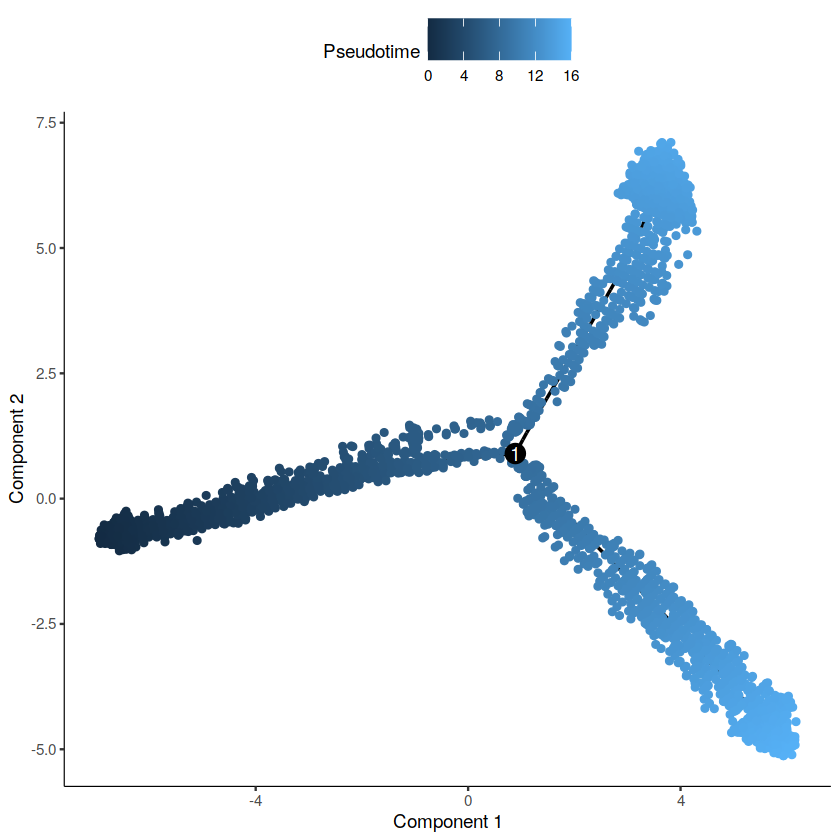

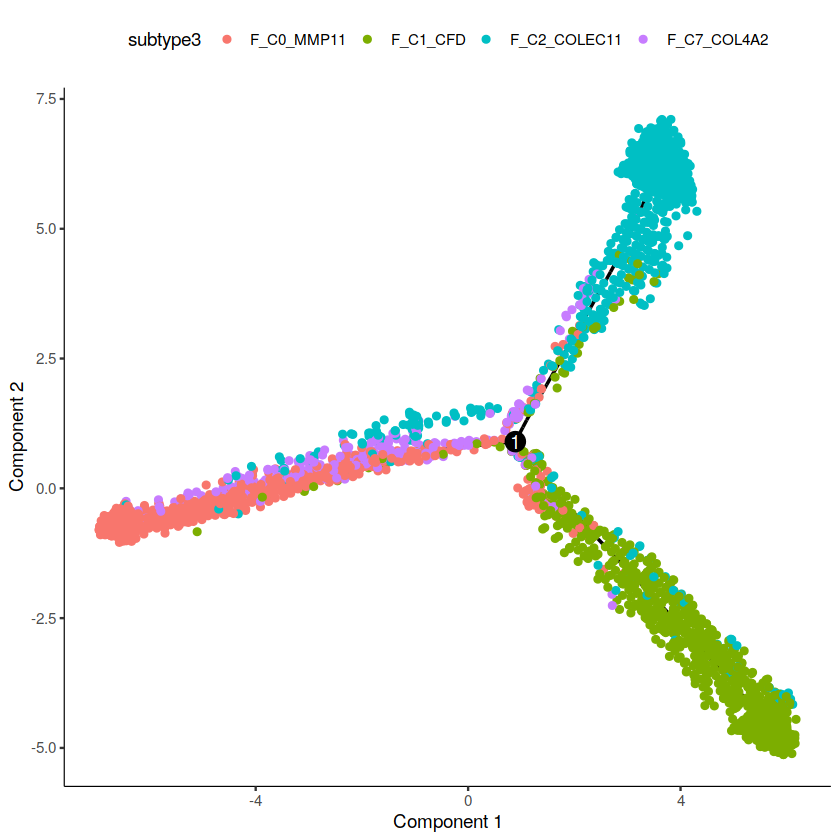

In [290]:
plot_cell_trajectory(cds, color_by = "Pseudotime")


plot_cell_trajectory(cds, color_by = "subtype3")

# subtype ratio in different groups

In [98]:
celltype_info = read.csv("/home/wyh/scdata/combined_data/meta_data/celltype20230312/celltype_fibroblast20230312.csv",row.names = 1)
dim(celltype_info)
#celltype_info = celltype_info[!(celltype_info$celltype %in% c("vSMC","pericytes","EMT_associated")),]
#celltype_info$subtype =  gsub("-",".",celltype_info$subtype)

[1] 78485     3

In [104]:
# 根据细胞的barcode取出病人的ID
orig.ident = lapply(celltype_info$cellid,
    FUN = function(i){
    data_split = unlist(strsplit(i,split = "_"))
    name = paste(data_split[1:(length(data_split)-1)],collapse = '_')
    #name = do.call(data_split[paste,args = data_split[1:(length(data_split)-1)]])
        return(name)
                      })
orig.ident = unlist(orig.ident)
celltype_info$orig.ident = orig.ident

In [105]:
fibroblast_num = as.data.frame.array(table(orig.ident))
fibroblast_little_patient = rownames(fibroblast_num)[fibroblast_num<20]
fibroblast_little_patient

[1] "GBC_047_PO" "GBC_048_P"  "GBC_049_P"  "GBC_054_LI" "GBC_058_LN"
 [6] "GBC_062_LN" "GBC_069_LI" "GBC_069_LM" "GBC_071_LI" "GBC_071_LN"
[11] "GBC_074_P"  "GBC_078_LN"

In [106]:
celltype_info = celltype_info[!celltype_info$orig.ident %in% fibroblast_little_patient,]

In [107]:
cluster_num = length(unique(celltype_info$subtype))

In [108]:
fibroblast_ratio_all = as.data.frame.array(table(celltype_info[,c("orig.ident","subtype")]))
# write.csv(fibroblast_ratio_all,"./group_compare/sample_fibroblast_subtype_number.csv")
fibroblast_ratio_all = fibroblast_ratio_all/rowSums(fibroblast_ratio_all)
fibroblast_ratio_all = cbind(fibroblast_ratio_all,patient_info[rownames(fibroblast_ratio_all),])

fibroblast_ratio_all$number =  rowSums(as.data.frame.array(table(celltype_info[,c("orig.ident","subtype")])))

In [26]:
write.csv(fibroblast_ratio_all,"./group_compare/fibroblast_ratio_all0816.csv")

In [118]:
fibroblast_ratio_all = read.csv("./group_compare/fibroblast_ratio_all0816.csv",row.names = 1)

# figure S7J

In [291]:
Fibroblast_new2 = readRDS("./Fibroblast_new2.RDS")
pdf("./submit/VEGFB_expression.pdf")
DotPlot(Fibroblast_new2[,Fibroblast_new2$subtype3 %in% c("F_C1_CFD","F_C0_MMP11",'F_C2_COLEC11',"Per_C0_RGS5","Per_C1_MYH11","Per_C3_STEAP4")],features = "VEGFB")
dev.off()

png 
  2

# figureS7E F_C7_COL4A2_metastasis.location

In [6]:
fibroblast_ratio_all = read.csv("./group_compare/fibroblast_ratio_all0816.csv",row.names = 1)

In [14]:
cluster_num = 16

In [20]:
fibroblast_ratio = fibroblast_ratio_all
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"Tumors.for.scRNA.seq.short")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("Tumors.for.scRNA.seq.short","variable","Freq")

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using Tumors.for.scRNA.seq.short as id variables



In [21]:
data_plot_melt_C2 = data_plot_melt[data_plot_melt$variable=="F_C7_COL4A2",]

In [24]:
data_plot_melt_C2 = data_plot_melt_C2[data_plot_melt_C2$Tumors.for.scRNA.seq.short %in% c("P","PO","LN","LI","LM","OM"),]

In [25]:
data_plot_melt_C2$Tumors.for.scRNA.seq.short = factor(data_plot_melt_C2$Tumors.for.scRNA.seq.short,levels = c("P","PO","LN","LI","LM","OM"))

In [26]:
get_adj_p <- function(data, .col, .grp = "Sample", comparisons = NULL,
                      method = "wilcox.test", p.adjust.method = "fdr", p.digits = 3L,symnum.args = NULL, ...) {
  # Compute p-values
  comparison.formula <- paste0(.col, "~", .grp) %>%
    as.formula()
  pvalues <- ggpubr::compare_means(
    formula = comparison.formula, data = data,
    method = method,
    p.adjust.method = p.adjust.method,
    ...
  )
  
  # If a comparison list is provided, extract the comparisons of interest for plotting
  if (!is.null(comparisons)) {
    pvalues <- purrr::map_df(comparisons, ~ pvalues %>% dplyr::filter(group1 == .x[1] & group2 == .x[2]))
  }
  
  # P-value y coordinates
  y.max <- data %>%
    dplyr::pull(.col) %>%
    max(na.rm = TRUE)
  p.value.y.coord <- rep(y.max, nrow(pvalues))
  
  step.increase <- (1:nrow(pvalues)) * (y.max / 10)
  p.value.y.coord <- p.value.y.coord + step.increase
  if (is.null(symnum.args)){
    symnum.args <- list(cutpoints = c(0, 1e-04, 0.001, 0.01, 
                                      0.05, 1), symbols = c("****", "***", "**", "*", 
                                                            "ns"))
  } 
    
  symnum.args$x <- as.numeric(pvalues$p.adj)
  p.adj.signif <- do.call(stats::symnum, symnum.args) %>% 
    as.character()
  pvalues$p.adj.signif = p.adj.signif
  pvalues <- pvalues %>%
    dplyr::mutate(
      y.position = p.value.y.coord,
      p.adj = format.pval(.data$p.adj, digits = p.digits)

    )
  
  pvalues
}

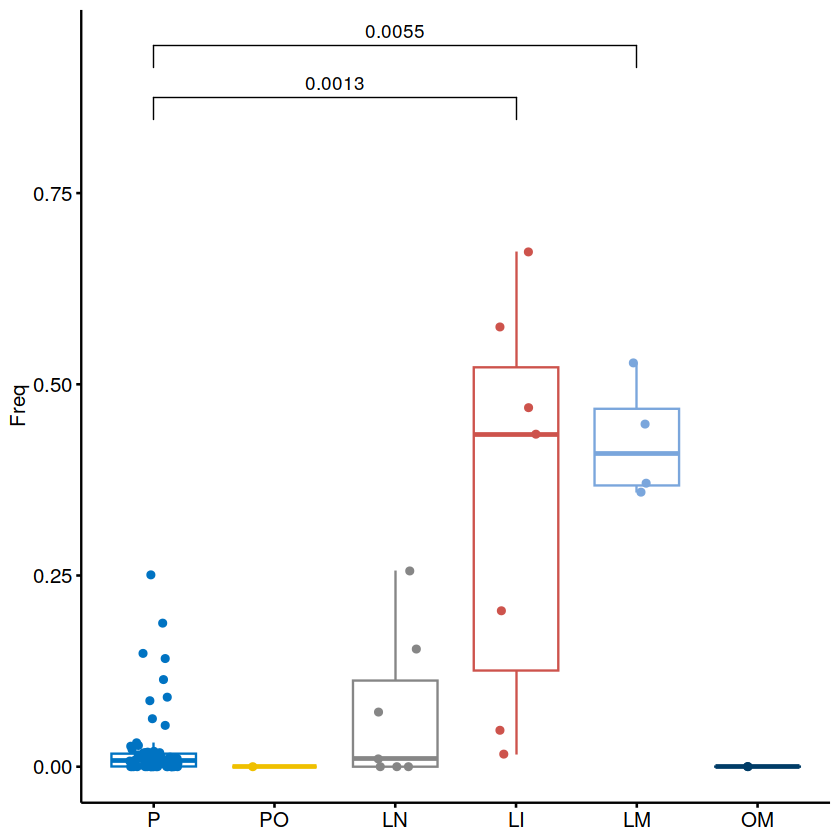

In [28]:
p_adj <- get_adj_p(data_plot_melt_C2,
                     .col = "Freq", .grp = "Tumors.for.scRNA.seq.short", p.adjust.method = "BH",
                     comparisons = list(c("P","PO"),c("P","LN"),c("P","LI"),c("P","LM"),c("P","OM")))
p <- ggboxplot(data_plot_melt_C2, x = "Tumors.for.scRNA.seq.short", y = "Freq", color = "Tumors.for.scRNA.seq.short", palette = "jco",add = "jitter") + 
    stat_pvalue_manual(p_adj, label = "p.adj", hide.ns = T)+
    theme(legend.position = "top") +
    theme(axis.title.x = element_blank(),
         legend.position = "none") 
p

In [137]:
pdf("./group_compare/F_C7_COL4A2_metastasis.location.pdf",width = 3,height = 3)
print(p)
dev.off()

png 
  2

# focus on iCAF

In [299]:
#
# Fibroblast_iCAFs = Fibroblast_new2[,Fibroblast_new2$subtype3=="F_C1_CFD"]
Fibroblast_iCAFs = Fibroblast_iCAFs_all[,Fibroblast_iCAFs_all$Tumors.for.scRNA.seq.short=="P"]
Fibroblast_iCAFs = Fibroblast_iCAFs[,Fibroblast_iCAFs$histological.type.short=="adeno"]
# Fibroblast_iCAFs = Fibroblast_iCAFs[,Fibroblast_iCAFs$seurat_clusters=="1"]
# Fibroblast_iCAFs = seurat_pipline(Fibroblast_iCAFs)

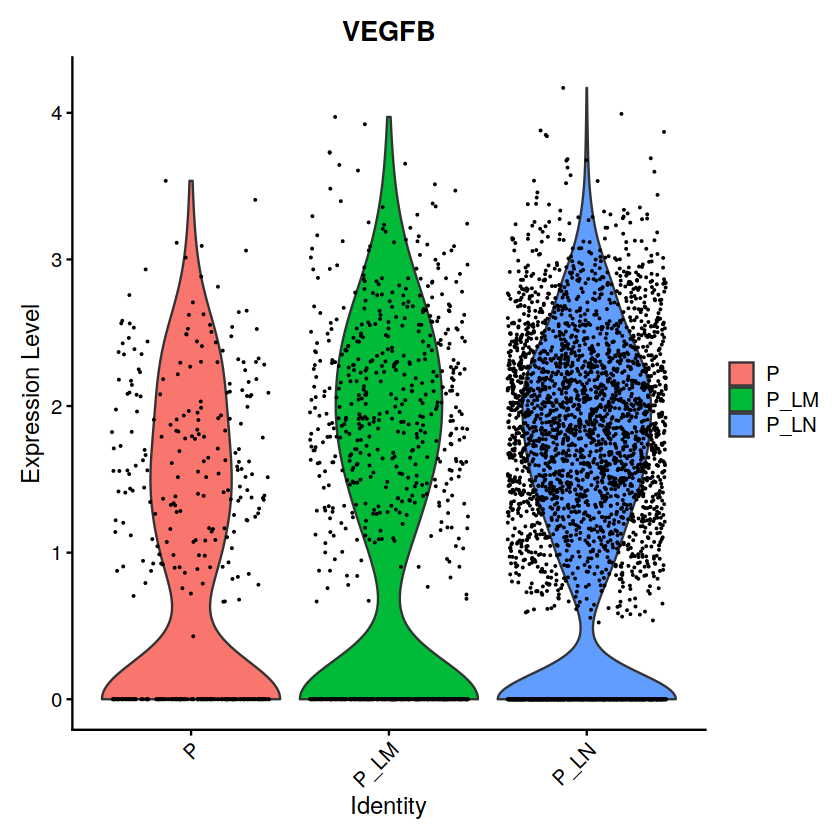

In [304]:
VlnPlot(Fibroblast_iCAFs,features = "VEGFB",group.by = "metastasis.type")

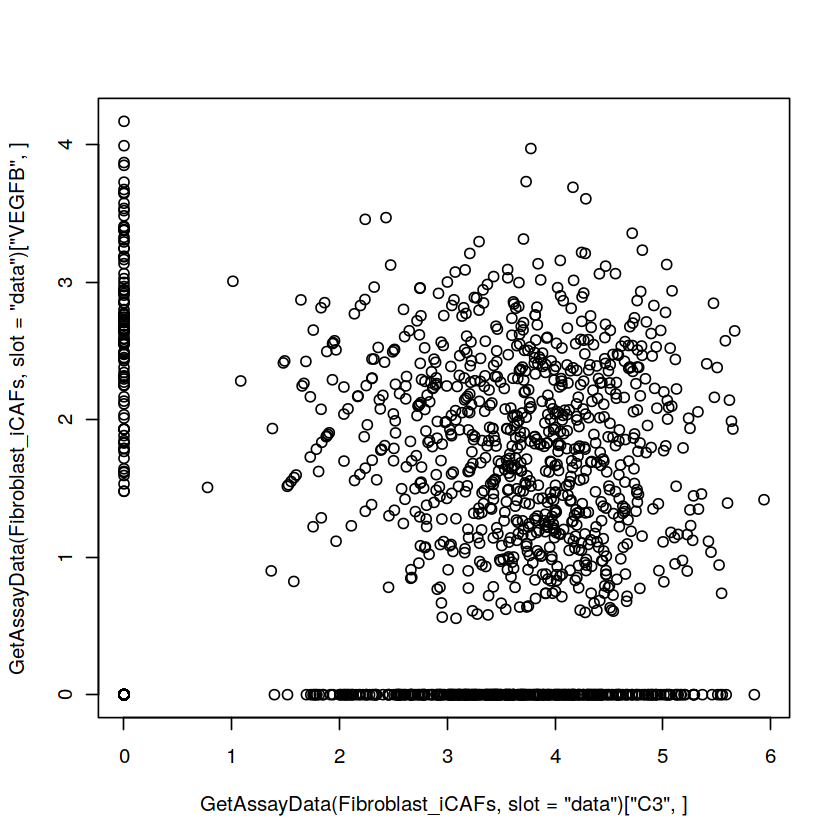

In [1508]:
plot(GetAssayData(Fibroblast_iCAFs,slot = "data")["C3",],GetAssayData(Fibroblast_iCAFs,slot = "data")["VEGFB",])

In [1509]:
cor.test(GetAssayData(Fibroblast_iCAFs,slot = "data")["C3",],GetAssayData(Fibroblast_iCAFs,slot = "data")["VEGFB",])


	Pearson's product-moment correlation

data:  GetAssayData(Fibroblast_iCAFs, slot = "data")["C3", ] and GetAssayData(Fibroblast_iCAFs, slot = "data")["VEGFB", ]
t = 1.1745, df = 1520, p-value = 0.2404
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.02016533  0.08023620
sample estimates:
       cor 
0.03011139 


## the relationship between proportion of endothelial cells and gene expression 

In [1439]:
data_plot = data.frame(expr = GetAssayData(Fibroblast_iCAFs,slot = "data")["C3",],ident = Fibroblast_iCAFs$NewSample.ID)

In [1440]:
attach(data_plot)
expr_mean = aggregate(data_plot, by = list(ident), FUN = mean)

The following object is masked from data_plot (pos = 4):

    expr


The following object is masked from data_plot (pos = 5):

    expr


The following object is masked from data_plot (pos = 6):

    expr


The following object is masked from data_plot (pos = 7):

    expr


The following object is masked from data_plot (pos = 8):

    expr


The following object is masked from data_plot (pos = 9):

    expr


The following object is masked from data_plot (pos = 10):

    expr


The following object is masked from data_plot (pos = 12):

    expr


The following object is masked from data_plot (pos = 13):

    expr


The following objects are masked from data_plot (pos = 14):

    expr, ident


The following objects are masked from data_plot (pos = 15):

    expr, ident


The following objects are masked from data_plot (pos = 16):

    expr, ident


The following objects are masked from data_plot (pos = 17):

    expr, ident


The following objects are masked from data_plot (pos = 18):


In [1441]:
head(expr_mean)

,Group.1,expr,ident
,<chr>,<dbl>,<dbl>
1,CC_004,2.952585,NA
2,CC_006,2.639495,NA
3,CC_007,3.287949,NA
4,CC_008,2.541826,NA
5,GBC_002_P,2.762584,NA
6,GBC_003_P,3.546047,NA


In [825]:
celltype_info = read.csv("/home/wyh/scdata/combined_data/meta_data/celltype_upload.txt",sep = "\t")

In [842]:
rownames(celltype_info) = celltype_info$name

In [838]:
orig.ident = lapply(celltype_info$name,
        FUN = function(i){
        data_split = unlist(strsplit(i,split = "_"))
        name = paste(data_split[1:(length(data_split)-1)],collapse = '_')
        #name = do.call(data_split[paste,args = data_split[1:(length(data_split)-1)]])
            return(name)
                          })
orig.ident = unlist(orig.ident)
celltype_info$orig.ident = orig.ident
celltype_info = as.data.frame(celltype_info)
celltype_info$barcode = celltype_info$name

In [843]:
head(celltype_info)

,name,X,Y,celltype,subtype,orig.ident,barcode
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
CC_004_AAACCCACAAGGCTTT,CC_004_AAACCCACAAGGCTTT,3.864054,13.460858,CD8+ T cell,CD8T_C18_IFIT2,CC_004,CC_004_AAACCCACAAGGCTTT
CC_004_AAACCCACACAGAGAC,CC_004_AAACCCACACAGAGAC,-9.371987,20.751965,Mast cells,Mast,CC_004,CC_004_AAACCCACACAGAGAC
CC_004_AAACCCACATGGAATA,CC_004_AAACCCACATGGAATA,2.219127,17.648360,NK cells,NK_C0_FCGR3A,CC_004,CC_004_AAACCCACATGGAATA
CC_004_AAACGAACAATTTCCT,CC_004_AAACGAACAATTTCCT,-8.546733,3.161771,Monocytes & Macrophages,M_C0_FOLR2,CC_004,CC_004_AAACGAACAATTTCCT
CC_004_AAACGAACACTTCTCG,CC_004_AAACGAACACTTCTCG,3.102727,14.022027,CD8+ T cell,CD8T_C18_IFIT2,CC_004,CC_004_AAACGAACACTTCTCG
CC_004_AAACGAACATCGTGGC,CC_004_AAACGAACATCGTGGC,2.310302,15.796511,CD8+ T cell,CD8T_C18_IFIT2,CC_004,CC_004_AAACGAACATCGTGGC


In [846]:
celltype_info_immune = celltype_info[celltype_info$celltype!="Epithelial cells",]

In [848]:
ratio_all = as.data.frame.array(table(celltype_info_immune[,c("orig.ident","subtype")]))

In [851]:
ratio_all = ratio_all/rowSums(ratio_all)

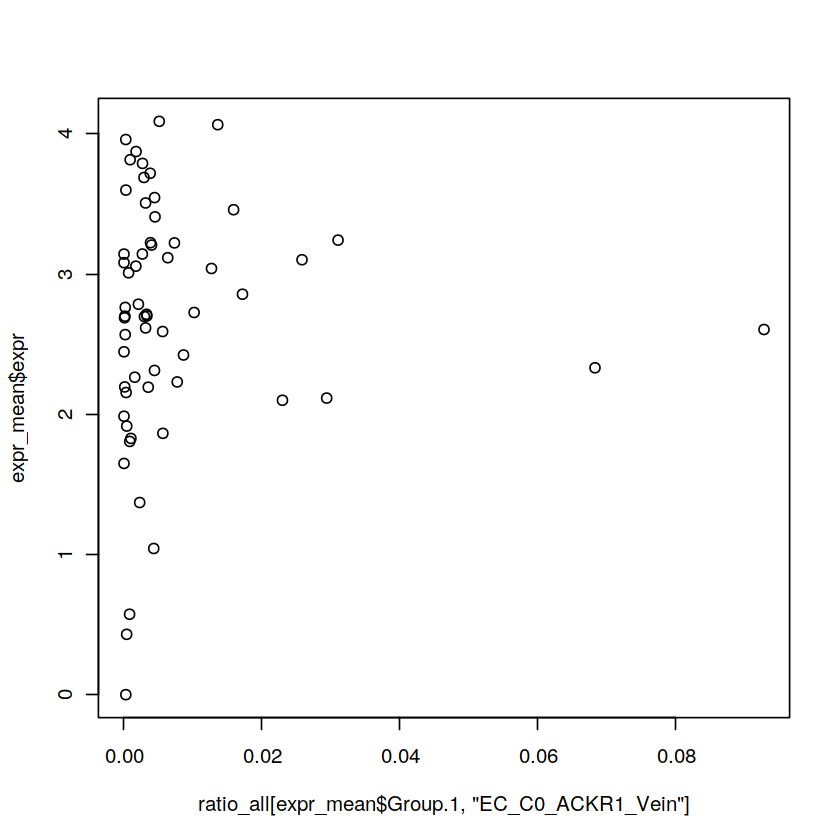

In [855]:
plot(ratio_all[expr_mean$Group.1,"EC_C0_ACKR1_Vein"],expr_mean$expr)

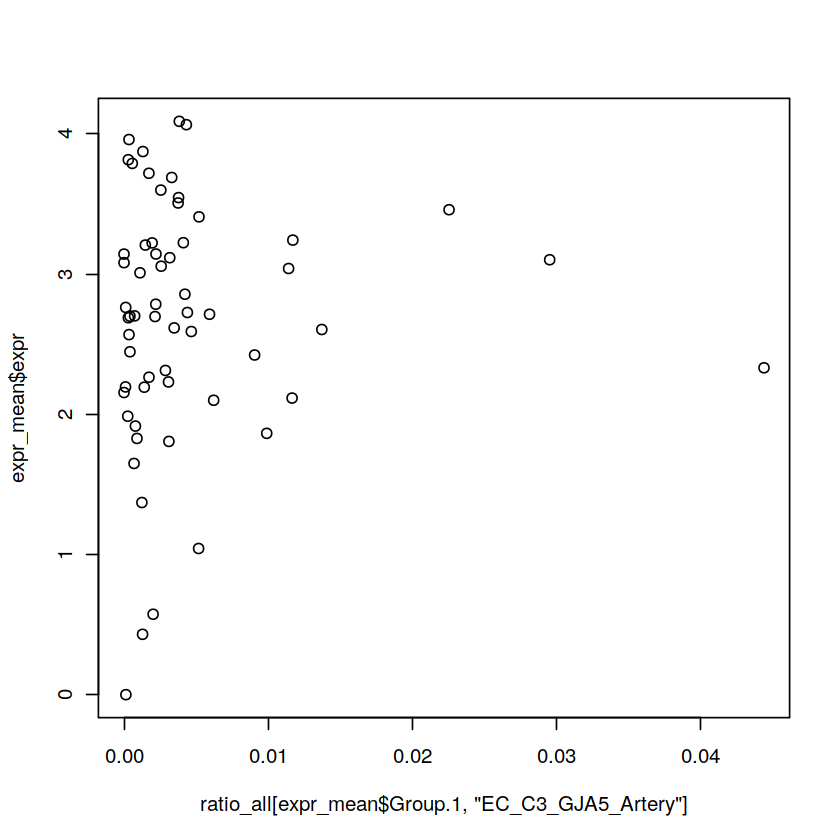

In [862]:
plot(ratio_all[expr_mean$Group.1,"EC_C3_GJA5_Artery"],expr_mean$expr)

In [996]:
iCAF_markers = Fibroblast_new2.markers[Fibroblast_new2.markers$cluster=="C1-CFD",]

In [1002]:
iCAF_markers[intersect(iCAF_markers$gene,complement_hallmarks$gene),]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
C3,0.000000e+00,2.1815008,0.876,0.355,0.000000e+00,C1-CFD,C3
CLU,0.000000e+00,1.1985548,0.747,0.359,0.000000e+00,C1-CFD,CLU
CFH,0.000000e+00,0.8189347,0.803,0.603,0.000000e+00,C1-CFD,CFH
C1S,0.000000e+00,0.8174547,0.911,0.717,0.000000e+00,C1-CFD,C1S
TIMP1,0.000000e+00,0.7835304,0.990,0.954,0.000000e+00,C1-CFD,TIMP1
C1R,0.000000e+00,0.7697311,0.932,0.773,0.000000e+00,C1-CFD,C1R
LRP1,0.000000e+00,0.7654909,0.806,0.596,0.000000e+00,C1-CFD,LRP1
SERPING1,0.000000e+00,0.5949441,0.892,0.763,0.000000e+00,C1-CFD,SERPING1
LGALS3,0.000000e+00,0.5234868,0.873,0.738,0.000000e+00,C1-CFD,LGALS3


In [1482]:
complement_KEGG = read.gmt("/home/wyh/database/msigdb/KEGG_COMPLEMENT_AND_COAGULATION_CASCADES.v2023.1.Hs.gmt")

Warning message in readLines(gmtfile):
“incomplete final line found on '/home/wyh/database/msigdb/KEGG_COMPLEMENT_AND_COAGULATION_CASCADES.v2023.1.Hs.gmt'”


In [1483]:
sum(complement_hallmarks$gene=="COLEC11")

[1] 0

In [1484]:
complement_hallmarks = read.gmt("/home/wyh/database/msigdb/HALLMARK_COMPLEMENT.v2023.1.Hs.gmt")

Warning message in readLines(gmtfile):
“incomplete final line found on '/home/wyh/database/msigdb/HALLMARK_COMPLEMENT.v2023.1.Hs.gmt'”


In [1485]:
Fibroblast_iCAFs = AddModuleScore(Fibroblast_iCAFs,features = list(KEGG = c(complement_KEGG$gene),hallmarks = complement_hallmarks$gene),name = "complement")

Warning message:
“The following features are not present in the object: SERPINE1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CEBPB, CXCL1, HSPA1A, HSPA5, IL6, IRF1, MAFF, SERPINE1, TNFAIP3, not searching for symbol synonyms”


In [1446]:
library("plotrix")

In [1486]:
expr_mean_list = list()

In [1511]:
Clinical.stage = Fibroblast_iCAFs$Clinical.stage

In [1512]:
table(Clinical.stage)

Clinical.stage
   I  IIB IIIA IIIB  IVA  IVB 
  23   15  109  440  115  820 

In [1513]:
Fibroblast_iCAFs

An object of class Seurat 
31925 features across 1522 samples within 1 assay 
Active assay: RNA (31925 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [1514]:
data_plot1 = data.frame(expr = GetAssayData(Fibroblast_iCAFs,slot = "data")["C3",])
expr_mean = aggregate(data_plot1, by = list(Clinical.stage), FUN = mean)
expr_se = aggregate(data_plot1, by = list(Clinical.stage), FUN = std.error)
expr_mean$se = expr_se$expr
rownames(expr_mean) = expr_mean$`Group.1`
expr_mean$mean = expr_mean$expr
expr_mean$group = "C3"
expr_mean$Clinical.stage = expr_mean$`Group.1`
head(expr_mean)
expr_mean_list[[1]] = expr_mean

,Group.1,expr,se,mean,group,Clinical.stage
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
I,I,2.965389,0.26728351,2.965389,C3,I
IIB,IIB,2.777070,0.55646346,2.777070,C3,IIB
IIIA,IIIA,3.500264,0.09814732,3.500264,C3,IIIA
IIIB,IIIB,3.376990,0.06967922,3.376990,C3,IIIB
IVA,IVA,3.189511,0.14954139,3.189511,C3,IVA
IVB,IVB,2.855229,0.05679599,2.855229,C3,IVB


In [1515]:
data_plot1 = data.frame(expr = GetAssayData(Fibroblast_iCAFs,slot = "data")["CXCL12",])
expr_mean = aggregate(data_plot1, by = list(Clinical.stage), FUN = mean)
expr_se = aggregate(data_plot1, by = list(Clinical.stage), FUN = std.error)
expr_mean$se = expr_se$expr
rownames(expr_mean) = expr_mean$`Group.1`
expr_mean$mean = expr_mean$expr
expr_mean$group = "CXCL12"
expr_mean$Clinical.stage = expr_mean$`Group.1`
head(expr_mean)
expr_mean_list[[2]] = expr_mean

,Group.1,expr,se,mean,group,Clinical.stage
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
I,I,1.487066,0.24448800,1.487066,CXCL12,I
IIB,IIB,2.119868,0.38650158,2.119868,CXCL12,IIB
IIIA,IIIA,2.125140,0.10912654,2.125140,CXCL12,IIIA
IIIB,IIIB,1.678185,0.05512369,1.678185,CXCL12,IIIB
IVA,IVA,1.595540,0.10839971,1.595540,CXCL12,IVA
IVB,IVB,1.481899,0.04331418,1.481899,CXCL12,IVB


In [1516]:
data_plot1 = data.frame(expr = GetAssayData(Fibroblast_iCAFs,slot = "data")["VEGFB",])
expr_mean = aggregate(data_plot1, by = list(Clinical.stage), FUN = mean)
expr_se = aggregate(data_plot1, by = list(Clinical.stage), FUN = std.error)
expr_mean$se = expr_se$expr
rownames(expr_mean) = expr_mean$`Group.1`
expr_mean$mean = expr_mean$expr
expr_mean$group = "VEGFB"
expr_mean$Clinical.stage = expr_mean$`Group.1`
head(expr_mean)
expr_mean_list[[3]] = expr_mean

,Group.1,expr,se,mean,group,Clinical.stage
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
I,I,1.3477766,0.25572914,1.3477766,VEGFB,I
IIB,IIB,1.2145548,0.32599396,1.2145548,VEGFB,IIB
IIIA,IIIA,0.6474047,0.07111329,0.6474047,VEGFB,IIIA
IIIB,IIIB,1.2948003,0.04865888,1.2948003,VEGFB,IIIB
IVA,IVA,1.3939614,0.08706542,1.3939614,VEGFB,IVA
IVB,IVB,1.2154186,0.03956221,1.2154186,VEGFB,IVB


In [1517]:
data_plot1 = data.frame(expr = Fibroblast_iCAFs$complement1)
expr_mean = aggregate(data_plot1, by = list(Clinical.stage), FUN = mean)
expr_se = aggregate(data_plot1, by = list(Clinical.stage), FUN = std.error)
expr_mean$se = expr_se$expr
rownames(expr_mean) = expr_mean$`Group.1`
expr_mean$mean = expr_mean$expr
expr_mean$group = "KEGG_complement"
expr_mean$Clinical.stage = expr_mean$`Group.1`
head(expr_mean)
expr_mean_list[[4]] = expr_mean

ERROR: Error: Cannot find 'complement1' in this Seurat object


In [1494]:
data_plot1 = data.frame(expr = Fibroblast_iCAFs$complement2)
expr_mean = aggregate(data_plot1, by = list(Clinical.stage), FUN = mean)
expr_se = aggregate(data_plot1, by = list(Clinical.stage), FUN = std.error)
expr_mean$se = expr_se$expr
rownames(expr_mean) = expr_mean$`Group.1`
expr_mean$mean = expr_mean$expr
expr_mean$group = "hallmarks_complement"
expr_mean$Clinical.stage = expr_mean$`Group.1`
head(expr_mean)
expr_mean_list[[5]] = expr_mean

,Group.1,expr,se,mean,group,Clinical.stage
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
I,I,0.1492142,0.008617089,0.1492142,hallmarks_complement,I
IIB,IIB,0.1563351,0.023111801,0.1563351,hallmarks_complement,IIB
IIIA,IIIA,0.1696217,0.003709209,0.1696217,hallmarks_complement,IIIA
IIIB,IIIB,0.1674165,0.002619912,0.1674165,hallmarks_complement,IIIB
IVA,IVA,0.1684194,0.001645365,0.1684194,hallmarks_complement,IVA
IVB,IVB,0.1475060,0.001002042,0.1475060,hallmarks_complement,IVB


In [1497]:
data_plot2 = data.frame(expr = GetAssayData(Fibroblast_iCAFs,slot = "data")["VEGFB",],complement = Fibroblast_iCAFs$complement2)

In [1498]:
cor.test(data_plot2$expr,data_plot2$complement)


	Pearson's product-moment correlation

data:  data_plot2$expr and data_plot2$complement
t = 4.7174, df = 3094, p-value = 2.494e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.04942583 0.11937776
sample estimates:
       cor 
0.08450592 


In [1499]:
expr_mean_df = do.call(rbind,expr_mean_list)

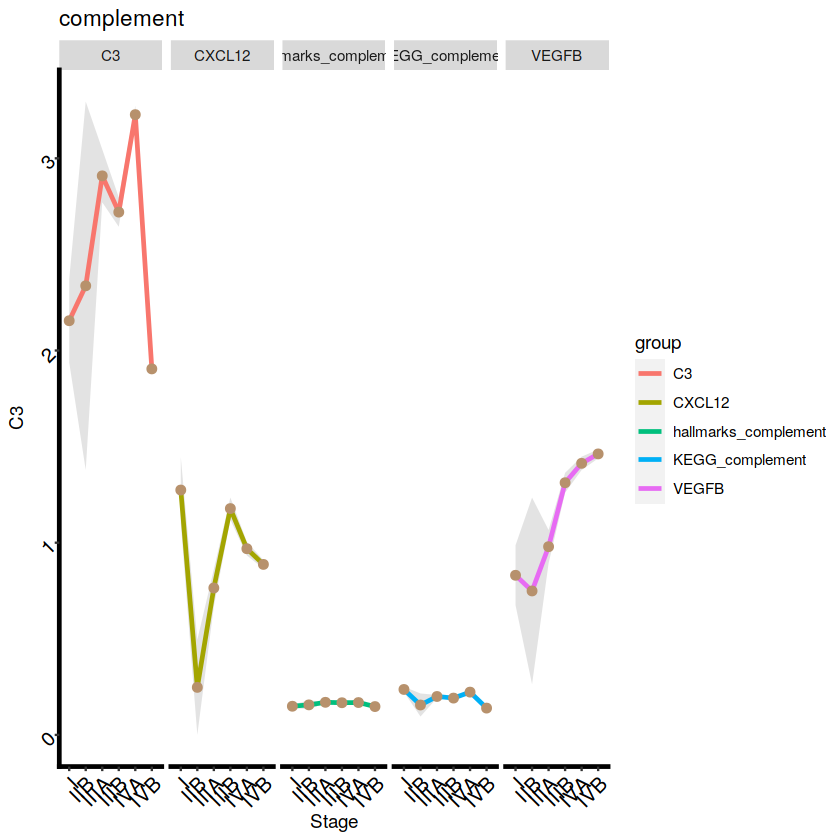

In [1500]:
ggplot(expr_mean_df,aes(Clinical.stage,mean,group = group))+
  geom_ribbon(aes(ymin=mean-se,ymax=mean+se),fill='#e3e3e3')+
  #geom_line(color=c('#B7916C'),size=1)+
  #geom_point(color='#B7916C',size=2)+
  geom_line(aes(color=group),size=1)+
  geom_point(color='#B7916C',size=2)+
  facet_grid(.~group)+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color="white"),
        # axis.title = element_blank(),
        #axis.ticks = element_blank(),
        axis.text.x=element_text(colour='black',size=12,angle = 45,hjust = 1))+
  ggtitle('complement')+theme(axis.line=element_line(colour='black',size=1,lineend = 'square'))+
  theme (axis.text.x = element_text (colour='black', size=12, angle=45), 
         axis.text.y = element_text (colour='black',size=12, angle=45))+
  labs(x='Stage',y='C3')

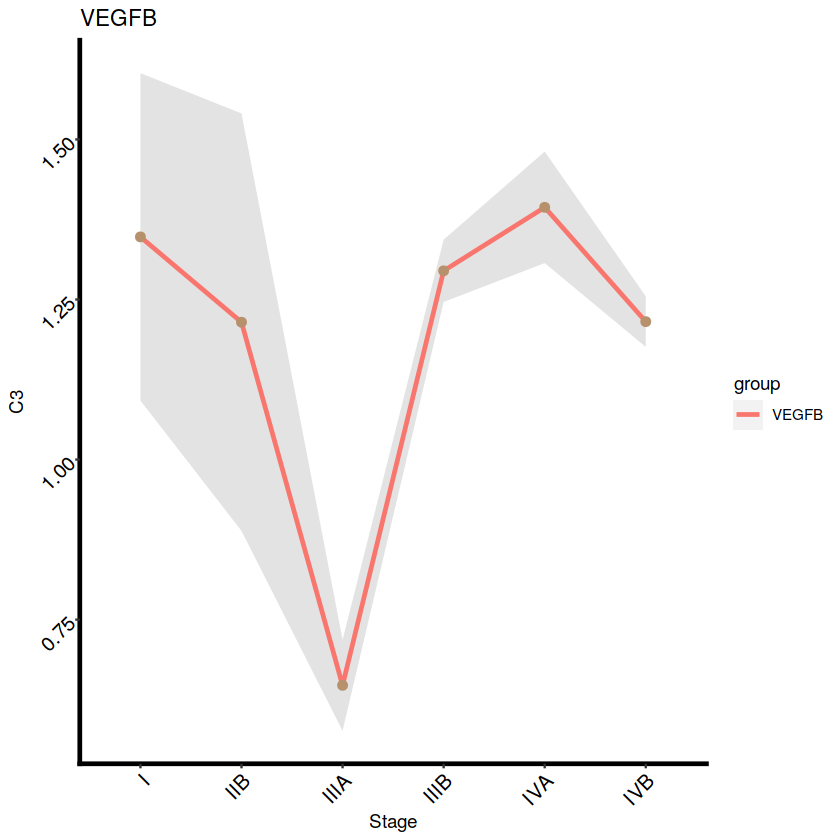

In [1518]:
ggplot(expr_mean_list[[3]],aes(Clinical.stage,mean,group = group))+
  geom_ribbon(aes(ymin=mean-se,ymax=mean+se),fill='#e3e3e3')+
  #geom_line(color=c('#B7916C'),size=1)+
  #geom_point(color='#B7916C',size=2)+
  geom_line(aes(color=group),size=1)+
  geom_point(color='#B7916C',size=2)+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color="white"),
        # axis.title = element_blank(),
        #axis.ticks = element_blank(),
        axis.text.x=element_text(colour='black',size=12,angle = 45,hjust = 1))+
  ggtitle('VEGFB')+theme(axis.line=element_line(colour='black',size=1,lineend = 'square'))+
  theme (axis.text.x = element_text (colour='black', size=12, angle=45), 
         axis.text.y = element_text (colour='black',size=12, angle=45))+
  labs(x='Stage',y='C3')

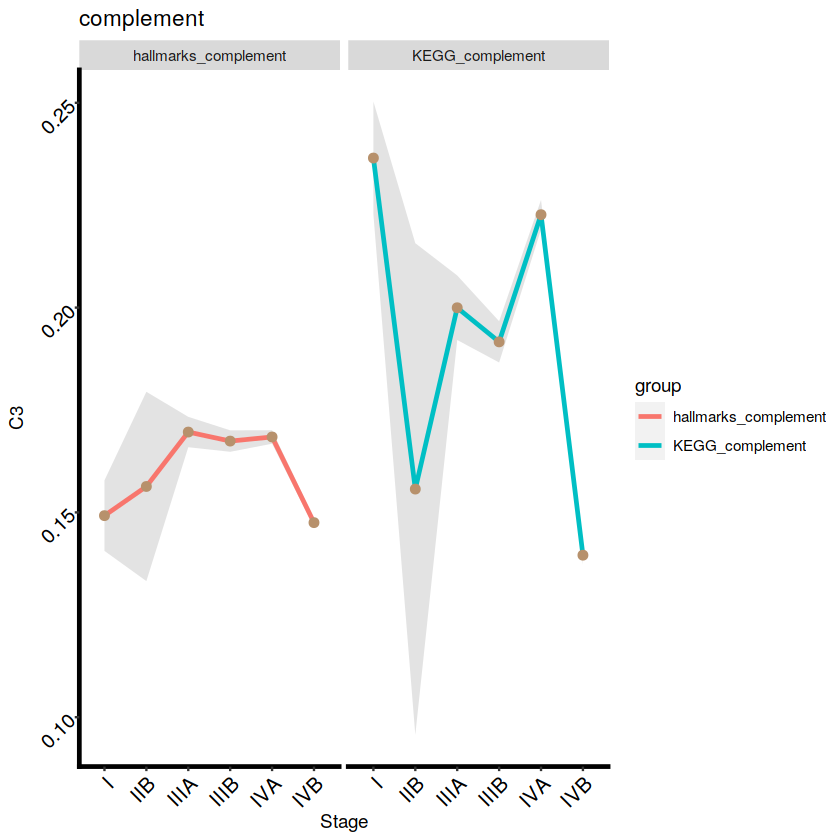

In [1501]:
ggplot(expr_mean_df[expr_mean_df$group %in% c("KEGG_complement",'hallmarks_complement'),],aes(Clinical.stage,mean,group = group))+
  geom_ribbon(aes(ymin=mean-se,ymax=mean+se),fill='#e3e3e3')+
  #geom_line(color=c('#B7916C'),size=1)+
  #geom_point(color='#B7916C',size=2)+
  geom_line(aes(color=group),size=1)+
  geom_point(color='#B7916C',size=2)+
  facet_grid(.~group)+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color="white"),
        # axis.title = element_blank(),
        #axis.ticks = element_blank(),
        axis.text.x=element_text(colour='black',size=12,angle = 45,hjust = 1))+
  ggtitle('complement')+theme(axis.line=element_line(colour='black',size=1,lineend = 'square'))+
  theme (axis.text.x = element_text (colour='black', size=12, angle=45), 
         axis.text.y = element_text (colour='black',size=12, angle=45))+
  labs(x='Stage',y='C3')

In [1036]:
pdf("./figures/complement.pdf",width = 10,height = 3)
ggplot(expr_mean_df,aes(Clinical.stage,mean,group = group))+
  geom_ribbon(aes(ymin=mean-se,ymax=mean+se),fill='#e3e3e3')+
  #geom_line(color=c('#B7916C'),size=1)+
  #geom_point(color='#B7916C',size=2)+
  geom_line(aes(color=group),size=1)+
  geom_point(color='#B7916C',size=2)+
  facet_grid(.~group)+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color="white"),
        # axis.title = element_blank(),
        #axis.ticks = element_blank(),
        axis.text.x=element_text(colour='black',size=12,angle = 45,hjust = 1))+
  ggtitle('complement')+theme(axis.line=element_line(colour='black',size=1,lineend = 'square'))+
  theme (axis.text.x = element_text (colour='black', size=12, angle=45), 
         axis.text.y = element_text (colour='black',size=12, angle=45))+
  labs(x='Stage',y='C3')
dev.off()

png 
  2

In [1037]:
pdf("./figures/complementV2.pdf",width = 6,height = 3)
ggplot(expr_mean_df[expr_mean_df$group %in% c("KEGG_complement",'hallmarks_complement'),],aes(Clinical.stage,mean,group = group))+
  geom_ribbon(aes(ymin=mean-se,ymax=mean+se),fill='#e3e3e3')+
  #geom_line(color=c('#B7916C'),size=1)+
  #geom_point(color='#B7916C',size=2)+
  geom_line(aes(color=group),size=1)+
  geom_point(color='#B7916C',size=2)+
  facet_grid(.~group)+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color="white"),
        # axis.title = element_blank(),
        #axis.ticks = element_blank(),
        axis.text.x=element_text(colour='black',size=12,angle = 45,hjust = 1))+
  ggtitle('complement')+theme(axis.line=element_line(colour='black',size=1,lineend = 'square'))+
  theme (axis.text.x = element_text (colour='black', size=12, angle=45), 
         axis.text.y = element_text (colour='black',size=12, angle=45))+
  labs(x='Stage',y='C3')
dev.off()

png 
  2

## figureS7H difference between P_Mets and P

In [1099]:
Fibroblast_iCAFs$metastasis.type[Fibroblast_iCAFs$metastasis.type %in% c("P_LN","P_LM")] = "P_Metas"

In [1107]:
markers_P_metas = FindMarkers(Fibroblast_iCAFs,group.by = "metastasis.type",ident.1 = "P_Metas",ident.2 = "P",min.pct = 0.20)

In [1102]:
write.csv(markers_P_metas,"./group_compare/Fibroblast_iCAFs.markers.csv")

In [254]:
markers_P_metas = read.csv("./group_compare/Fibroblast_iCAFs.markers.csv",row.name = 1)

In [255]:
head(markers_P_metas)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC005343.4,3.267587e-159,-0.4278258,0.000,0.168,1.043177e-154
C11orf96,2.479083e-29,1.2640175,0.837,0.751,7.914472e-25
GATD3A,6.824323e-28,-0.3342447,0.040,0.168,2.178665e-23
COL4A4,6.588656e-19,-0.5341989,0.153,0.327,2.103428e-14
MT1G,1.127850e-17,-0.7844910,0.045,0.147,3.600660e-13
CRLF1,3.358351e-17,-0.5753393,0.084,0.215,1.072154e-12


In [256]:
markers_P_metas$gene = rownames(markers_P_metas)

In [673]:
markers_P_metas_plot = markers_P_metas[markers_P_metas$gene!="AC005343.4",]
colnames(markers_P_metas_plot) = c("Pvalue","logFC","pct.1","pct.2","qvalue","gene")
pdf("/home/wyh/scdata/combined_data/fibroblast/submit/markers_P_metas_plot.pdf",height = 5,width = 4)
EnhancedVolcano::EnhancedVolcano(markers_P_metas_plot,
                title = "Differential expression", subtitle = "",
                selectLab = c("VEGFB",'HIF1A','CFD','CLU'),
                drawConnectors = TRUE, widthConnectors = 0.5, colConnectors = 'black', boxedLabels = TRUE,
                lab = markers_P_metas_plot$gene,
                col = c("grey30", "forestgreen", '#5956c8', '#dd3e34'),
                x = 'logFC',
                y = 'qvalue',
                xlim = c(-2, 2),
                FCcutoff = 0.25,
                pCutoff = 10e-2,
                legendLabSize = 10)+xlab(expression(paste("logFC",frac("P_Metas","P"))))
dev.off()

png 
  2

In [250]:
head(markers_P_metas)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AC005343.4,3.267587e-159,-0.4278258,0.000,0.168,1.043177e-154,AC005343.4
C11orf96,2.479083e-29,1.2640175,0.837,0.751,7.914472e-25,C11orf96
GATD3A,6.824323e-28,-0.3342447,0.040,0.168,2.178665e-23,GATD3A
COL4A4,6.588656e-19,-0.5341989,0.153,0.327,2.103428e-14,COL4A4
MT1G,1.127850e-17,-0.7844910,0.045,0.147,3.600660e-13,MT1G
CRLF1,3.358351e-17,-0.5753393,0.084,0.215,1.072154e-12,CRLF1


In [257]:
markers_P_metas_plotV2 = markers_P_metas
markers_P_metas_plotV2 = markers_P_metas_plotV2[markers_P_metas_plotV2$gene!="AC005343.4",]

In [262]:
markers_P_metas_plotV2[order(-markers_P_metas_plotV2$avg_log2FC),]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
C11orf96,2.479083e-29,1.2640175,0.837,0.751,7.914472e-25,C11orf96,UP
MT2A,4.815803e-11,0.9372720,0.915,0.869,1.537445e-06,MT2A,UP
AGT,2.903350e-08,0.8758205,0.262,0.136,9.268946e-04,AGT,UP
RGCC,7.125593e-08,0.8739314,0.225,0.110,2.274846e-03,RGCC,UP
GREM1,1.424433e-16,0.8410206,0.386,0.168,4.547502e-12,GREM1,UP
CHI3L1,2.459778e-03,0.8259243,0.125,0.073,1.000000e+00,CHI3L1,UP
SOD2,7.985230e-12,0.7617469,0.721,0.634,2.549285e-07,SOD2,UP
PTX3,2.311518e-02,0.7583088,0.119,0.084,1.000000e+00,PTX3,UP
MMP14,1.500640e-10,0.6755431,0.471,0.330,4.790795e-06,MMP14,UP


In [263]:
markers_P_metas_plotV2$threshold = "Non significant"
markers_P_metas_plotV2$threshold[markers_P_metas_plotV2$avg_log2FC>0] = "UP"
markers_P_metas_plotV2$threshold[markers_P_metas_plotV2$avg_log2FC<0] = 'DOWN'

In [266]:
markers_P_metas_plotV2$threshold = factor(markers_P_metas_plotV2$threshold,levels = c("UP",'DOWN',"Non significant"))

In [277]:
pdf("./submit/vocaloplot_P_P_metasV2.pdf",height = 3,width = 3)
library( ggrepel)
ggplot(markers_P_metas_plotV2,aes(x=avg_log2FC,y=-log10(p_val_adj),color=threshold))+
  geom_point()+
  scale_color_manual(values=c("#DC143C","#00008B","#808080"))+
  geom_text_repel(
    data = markers_P_metas_plotV2[markers_P_metas_plotV2$gene %in% c("VEGFB",'HIF1A'),],
    aes(label = gene),
    size = 3,
    segment.color = "black", show.legend = FALSE )+#添加关注的点的基因名
  theme_bw()+
  theme(
    legend.title = element_blank()
  )+
  ylab('-log10 (p-adj)')+
  xlab('log2 (FoldChange)')+
  geom_vline(xintercept=c(-1,1),lty=3,col="black",lwd=0.5) +
  geom_hline(yintercept = -log10(0.05),lty=3,col="black",lwd=0.5)+theme(legend.position="none")
  ggtitle("F_C1_CFD")
dev.off()

$title
[1] "F_C1_CFD"

attr(,"class")
[1] "labels"

png 
  2

### figureS7I enrichment analysis

In [283]:
library(clusterProfiler)



clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter




In [284]:
UP_enrichGO_result = enrichGO(gene = markers_P_metas[markers_P_metas$avg_log2FC>0 & markers_P_metas$p_val_adj<0.05,]$gene,'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01,keyType = "SYMBOL")

Loading required package: org.Hs.eg.db

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, ro

In [285]:
length(markers_P_metas[markers_P_metas$avg_log2FC>0 & markers_P_metas$p_val_adj<0.05,]$gene)

[1] 31

In [1127]:
pdf("/home/wyh/scdata/combined_data/fibroblast/submit/markers_P_metas_enrichedV2.pdf",height = 4,width =6)
dotplot(UP_enrichGO_result)
dev.off()

wrong orderBy parameter; set to default `orderBy = "x"`



png 
  2

In [1157]:
pdf("/home/wyh/scdata/combined_data/fibroblast/submit/markers_P_metas_enrichedV3.pdf",height = 4,width =7)
dotplot(UP_enrichGO_result)
dev.off()

wrong orderBy parameter; set to default `orderBy = "x"`



png 
  2

In [637]:
UP_enrichGO_result@result

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0097529,GO:0097529,myeloid leukocyte migration,6/27,222/18866,5.974147e-07,0.0009009014,0.0005640853,GREM1/VEGFB/MMP14/IL1R1/NBL1/PPIB,6
GO:1901342,GO:1901342,regulation of vasculature development,7/27,444/18866,2.253017e-06,0.0016987748,0.0010636612,GREM1/VEGFB/SOD2/HIF1A/AGT/RGCC/SPHK1,7
GO:0048771,GO:0048771,tissue remodeling,5/27,178/18866,4.821528e-06,0.0024236216,0.0015175126,GREM1/HIF1A/MMP14/CTHRC1/AGT,5
GO:0001935,GO:0001935,endothelial cell proliferation,5/27,199/18866,8.299843e-06,0.0031290408,0.0019591998,VEGFB/HIF1A/MMP14/RGCC/ERN1,5
GO:0002685,GO:0002685,regulation of leukocyte migration,5/27,212/18866,1.128062e-05,0.0034022344,0.0021302557,GREM1/VEGFB/MMP14/IL1R1/NBL1,5
GO:0045765,GO:0045765,regulation of angiogenesis,6/27,403/18866,1.852199e-05,0.0039955726,0.0025017651,GREM1/VEGFB/HIF1A/AGT/RGCC/SPHK1,6
GO:1904018,GO:1904018,positive regulation of vasculature development,5/27,235/18866,1.854709e-05,0.0039955726,0.0025017651,GREM1/VEGFB/SOD2/HIF1A/SPHK1,5
GO:0046916,GO:0046916,cellular transition metal ion homeostasis,4/27,116/18866,2.134787e-05,0.0040240727,0.0025196099,FTH1/HIF1A/MT2A/FTL,4
GO:0055076,GO:0055076,transition metal ion homeostasis,4/27,138/18866,4.220459e-05,0.0070716130,0.0044277795,FTH1/HIF1A/MT2A/FTL,4


In [613]:
down_enrichGO_result = enrichGO(gene = markers_P_metas[markers_P_metas$avg_log2FC<0 & markers_P_metas$p_val_adj<0.05,]$gene,'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01,keyType = "SYMBOL")

wrong orderBy parameter; set to default `orderBy = "x"`



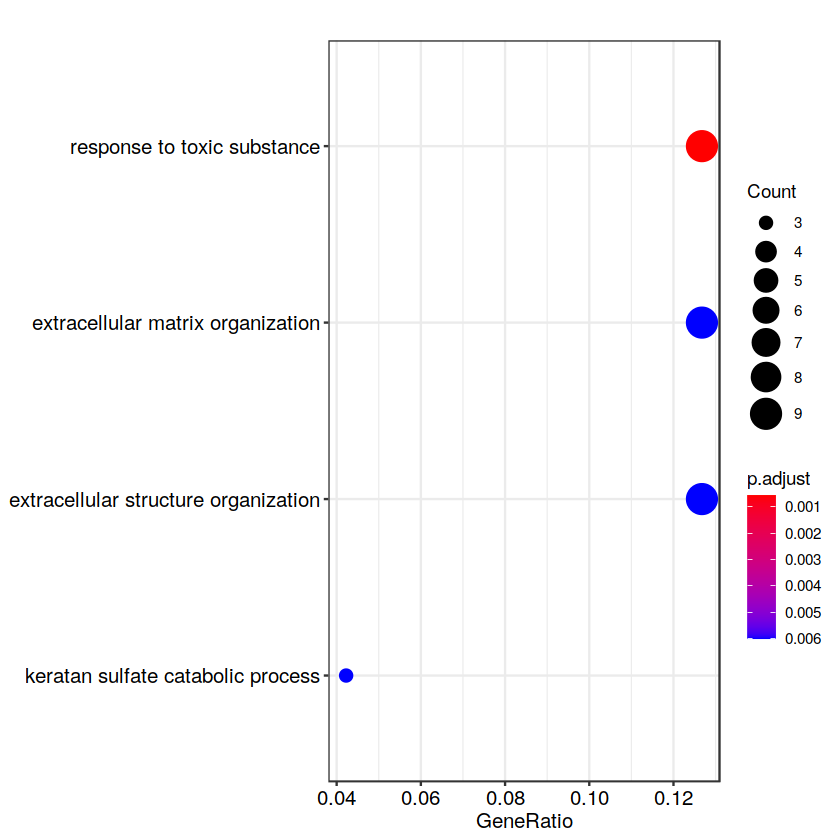

In [614]:
dotplot(down_enrichGO_result)

In [866]:
markers_P_metas[order(-markers_P_metas$avg_log2FC),]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C11orf96,2.479083e-29,1.2640175,0.837,0.751,7.914472e-25,C11orf96
MT2A,4.815803e-11,0.9372720,0.915,0.869,1.537445e-06,MT2A
AGT,2.903350e-08,0.8758205,0.262,0.136,9.268946e-04,AGT
RGCC,7.125593e-08,0.8739314,0.225,0.110,2.274846e-03,RGCC
GREM1,1.424433e-16,0.8410206,0.386,0.168,4.547502e-12,GREM1
CHI3L1,2.459778e-03,0.8259243,0.125,0.073,1.000000e+00,CHI3L1
SOD2,7.985230e-12,0.7617469,0.721,0.634,2.549285e-07,SOD2
PTX3,2.311518e-02,0.7583088,0.119,0.084,1.000000e+00,PTX3
MMP14,1.500640e-10,0.6755431,0.471,0.330,4.790795e-06,MMP14


In [617]:
enrichGO_result@result

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0009636,GO:0009636,response to toxic substance,9/71,250/18866,3.972947e-07,0.0005609802,0.0004742444,MT1G/INMT/PENK/CST3/FBLN5/GPX3/SOD3/EPHX1/MPST,9
GO:0042340,GO:0042340,keratan sulfate catabolic process,3/71,12/18866,1.096684e-05,0.0060167979,0.0050865132,OGN/PRELP/OMD,3
GO:0030198,GO:0030198,extracellular matrix organization,9/71,395/18866,1.670709e-05,0.0060167979,0.0050865132,COL4A4/FBLN2/VIT/CST3/FBLN5/DPT/SMOC2/FBLN1/MFAP5,9
GO:0043062,GO:0043062,extracellular structure organization,9/71,396/18866,1.704475e-05,0.0060167979,0.0050865132,COL4A4/FBLN2/VIT/CST3/FBLN5/DPT/SMOC2/FBLN1/MFAP5,9
GO:0044273,GO:0044273,sulfur compound catabolic process,4/71,56/18866,5.834467e-05,0.0157718803,0.0133333176,OGN/PRELP/OMD/MPST,4
GO:0007009,GO:0007009,plasma membrane organization,5/71,113/18866,6.701932e-05,0.0157718803,0.0133333176,GSN/CAVIN2/SPTBN1/CLU/NDRG1,5
GO:0072593,GO:0072593,reactive oxygen species metabolic process,7/71,288/18866,1.036648e-04,0.0209106680,0.0176775738,FBLN5/DDAH2/CD34/CLU/GPX3/SOD3/IFI6,7
GO:0043567,GO:0043567,regulation of insulin-like growth factor receptor signaling pathway,3/71,26/18866,1.247977e-04,0.0220267969,0.0186211329,CILP/IGFBP6/IGFBP5,3
GO:0042063,GO:0042063,gliogenesis,7/71,307/18866,1.539356e-04,0.0220835066,0.0186690745,PENK/GSN/PHGDH/NFIB/CLU/CCL2/NDRG1,7


In [ ]:
## HALLmarks的富集分析

wrong orderBy parameter; set to default `orderBy = "x"`



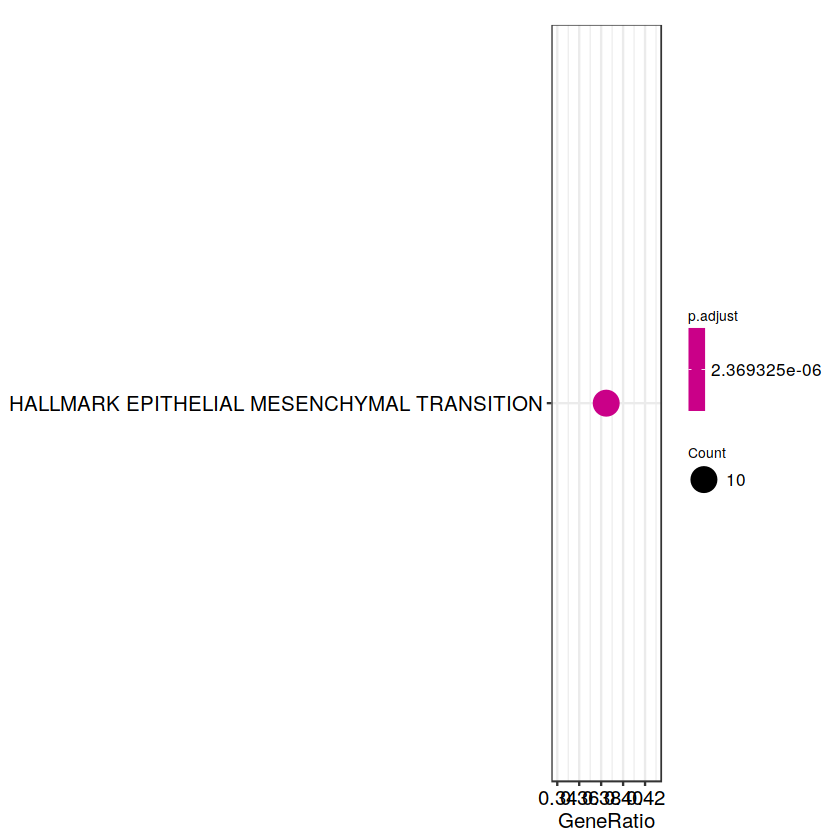

In [541]:
library(clusterProfiler)
library(stringr)

HALL_marks = read.csv("/home/wyh/database/msigdb/hallmarks.csv",row.names = 1)
HALL_marks$term = str_wrap(HALL_marks$term)

# gene_worse = markers_worse[markers_worse$logFC>0.5 & markers_worse$qvalue<0.01,]$gene
enrich_result = enricher(markers_worse[markers_worse$logFC>0.5 & markers_worse$qvalue<0.01,]$gene,TERM2GENE = HALL_marks)

# pdf("./experiment/scissors/result/figures/worse_enrich.pdf",height = 4,width = 7)
a = dotplot(enrich_result)+theme(text = element_text(size = 3),
                             legend.key.size = unit(10, "pt"),
                             legend.title = element_text(size = 8),
                             legend.text = element_text(size = 10))
a
# dev.off()

In [409]:
markers_up = markers_worse[(markers_worse$logFC>0.5) & (markers_worse$Pvalue < 0.05),]
markers_up

,Pvalue,logFC,pct.1,pct.2,qvalue,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C11orf96,2.479083e-29,1.2640175,0.837,0.751,7.914472e-25,C11orf96
GREM1,1.424433e-16,0.8410206,0.386,0.168,4.547502e-12,GREM1
VEGFB,2.677766e-14,0.5676470,0.715,0.558,8.548767e-10,VEGFB
SOD2,7.985230e-12,0.7617469,0.721,0.634,2.549285e-07,SOD2
HIF1A,4.195427e-11,0.5615803,0.449,0.293,1.339390e-06,HIF1A
MT2A,4.815803e-11,0.9372720,0.915,0.869,1.537445e-06,MT2A
COL6A3,8.931812e-11,0.5032797,0.875,0.885,2.851481e-06,COL6A3
MMP14,1.500640e-10,0.6755431,0.471,0.330,4.790795e-06,MMP14
IL1R1,5.771963e-09,0.5359489,0.668,0.586,1.842699e-04,IL1R1


In [796]:
ligand_receptor_pair = read.csv("/home/wyh/database/PairsLigRec.txt",sep = "")

In [1380]:
ligand_receptor_pair[ligand_receptor_pair$Ligand=="COLEC11","Receptor"]

character(0)

In [410]:
markers_up[intersect(markers_up$gene,unique(ligand_receptor_pair$Ligand)),]

,Pvalue,logFC,pct.1,pct.2,qvalue,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GREM1,1.424433e-16,0.8410206,0.386,0.168,4.547502e-12,GREM1
VEGFB,2.677766e-14,0.5676470,0.715,0.558,8.548767e-10,VEGFB
COL6A3,8.931812e-11,0.5032797,0.875,0.885,2.851481e-06,COL6A3
AGT,2.903350e-08,0.8758205,0.262,0.136,9.268946e-04,AGT
THBS1,2.083215e-06,0.6446813,0.609,0.545,6.650663e-02,THBS1
COL3A1,6.759055e-05,0.5142973,0.924,0.924,1.000000e+00,COL3A1
CXCL2,3.592765e-03,0.5441907,0.240,0.181,1.000000e+00,CXCL2


In [426]:
ligand_receptor_pair[ligand_receptor_pair$Ligand=="VEGFB",]

,Pair.Name,Ligand,Receptor
,<chr>,<chr>,<chr>
2455,VEGFB_FLT1,VEGFB,FLT1
2456,VEGFB_NRP1,VEGFB,NRP1
2457,VEGFB_RET,VEGFB,RET
2458,VEGFB_TYRO3,VEGFB,TYRO3


In [526]:
ligand_receptor_pair[ligand_receptor_pair$Ligand=="CFD",]

Pair.Name,Ligand,Receptor
<chr>,<chr>,<chr>


In [421]:
ligand_receptor_interesting = ligand_receptor_pair[ligand_receptor_pair$Ligand %in% intersect(markers_up$gene,unique(ligand_receptor_pair$Ligand)),]

In [424]:
write.csv(ligand_receptor_interesting,"./group_compare/ligand_receptor_interesting.csv")

In [368]:
temp = markers_worse
temp = temp[order(temp$logFC,decreasing = TRUE),]
temp_gene_list = temp$logFC
names(temp_gene_list) = temp$gene
a = GSEA(geneList = temp_gene_list,TERM2GENE = HALL_marks,pvalueCutoff = 0.05)
PT_deviated = a@result[,c("ID","NES",'p.adjust')]
PT_deviated

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



,ID,NES,p.adjust
,<chr>,<dbl>,<dbl>
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,2.162343,0.01957335
HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,2.027075,0.02942861


wrong orderBy parameter; set to default `orderBy = "x"`



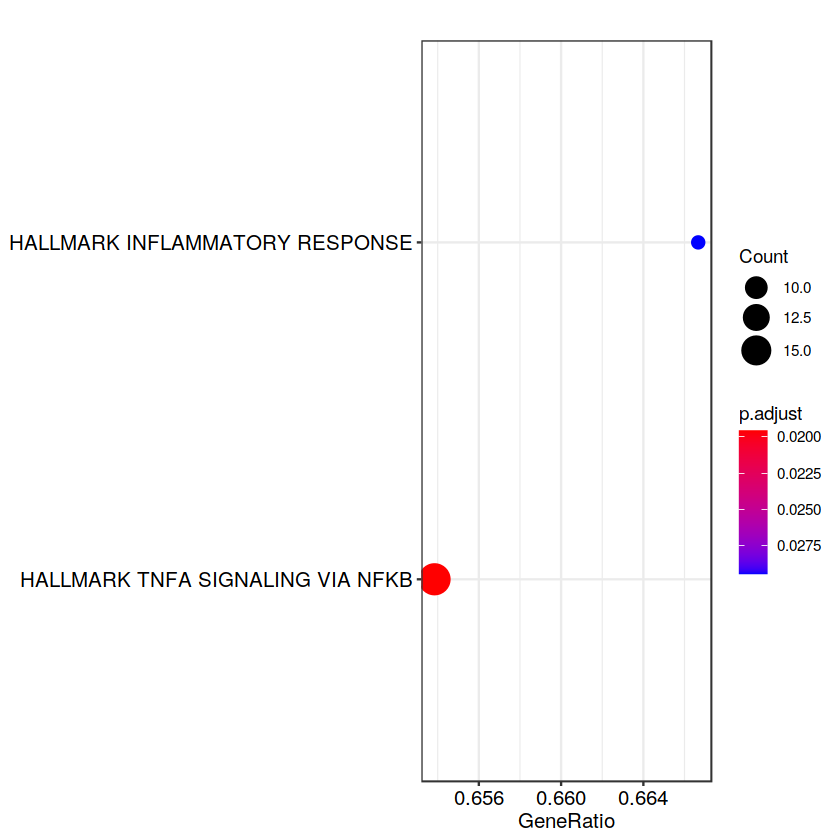

In [371]:
dotplot(a)

In [427]:
markers_filter = markers[markers$p_val_adj<0.05,]
head(markers_filter[order(-markers_filter$avg_log2FC),])

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C11orf96,2.479083e-29,1.2640175,0.837,0.751,7.914472e-25,C11orf96
MT2A,4.815803e-11,0.9372720,0.915,0.869,1.537445e-06,MT2A
AGT,2.903350e-08,0.8758205,0.262,0.136,9.268946e-04,AGT
RGCC,7.125593e-08,0.8739314,0.225,0.110,2.274846e-03,RGCC
GREM1,1.424433e-16,0.8410206,0.386,0.168,4.547502e-12,GREM1
SOD2,7.985230e-12,0.7617469,0.721,0.634,2.549285e-07,SOD2


## Figure S7F difference between normal and tumor

In [1128]:
Fibroblast_iCAFsV2 = Fibroblast_new2[,Fibroblast_new2$subtype3=="F_C1_CFD"]

In [1129]:
Fibroblast_iCAFsV2 = Fibroblast_iCAFsV2[,Fibroblast_iCAFsV2$histological.type.short %in% c("CC","XGC","LG","HG","adeno")]
# data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"sample.type")]

In [1132]:
Fibroblast_iCAFsV2$sample.type = "Tumor"

Fibroblast_iCAFsV2$sample.type[Fibroblast_iCAFsV2$Tumors.for.scRNA.seq.short %in% c("CC","XGC")] = "Normal"
Fibroblast_iCAFsV2$sample.type[Fibroblast_iCAFsV2$histological.type.short %in% c("LG","HG")] = "Normal"

In [1133]:
markers_adeno_iCAF = FindMarkers(Fibroblast_iCAFsV2,group.by = "sample.type",ident.1 = "Tumor",ident.2 = "Normal",min.pct = 0.20)

In [1134]:
write.csv(markers_adeno_iCAF,"./group_compare/adeno_iCAF_markers.csv")

In [269]:
markers_adeno_iCAF = read.csv("./group_compare/adeno_iCAF_markers.csv",row.names = 1)

In [271]:
markers_adeno_iCAF$gene = rownames(markers_adeno_iCAF)

In [684]:
markers_adeno_iCAF_plot = markers_adeno_iCAF
colnames(markers_adeno_iCAF_plot) = c("Pvalue","logFC","pct.1","pct.2","qvalue","gene")
pdf("/home/wyh/scdata/combined_data/fibroblast/submit/markers_adeno_iCAF_plot.pdf",height = 7,width = 6)
EnhancedVolcano::EnhancedVolcano(markers_adeno_iCAF_plot,
                title = "Differential expression", subtitle = "",
                selectLab = c("COL10A1",'COL4A2','COL8A1','MMP11','COL5A2','COL12A1','COL18A1','MMP14','CFD','CLU'),
                drawConnectors = TRUE, widthConnectors = 0.5, colConnectors = 'black', boxedLabels = TRUE,
                lab = markers_adeno_iCAF_plot$gene,
                col = c("grey30", "forestgreen", '#5956c8', '#dd3e34'),
                x = 'logFC',
                y = 'qvalue',
                xlim = c(-2, 2),
                FCcutoff = 0.25,
                pCutoff = 10e-2,
                legendLabSize = 10)+xlab(expression(paste("logFC",frac("tumor","normal"))))
dev.off()

Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


png 
  2

In [273]:
markers_adeno_iCAF_plot = markers_adeno_iCAF

In [274]:
markers_adeno_iCAF_plot$threshold = "Non significant"
markers_adeno_iCAF_plot$threshold[markers_adeno_iCAF_plot$avg_log2FC>0] = "UP"
markers_adeno_iCAF_plot$threshold[markers_adeno_iCAF_plot$avg_log2FC<0] = 'DOWN'

In [275]:
markers_adeno_iCAF_plot$threshold = factor(markers_adeno_iCAF_plot$threshold,levels = c("UP",'DOWN',"Non significant"))

In [278]:
pdf("./submit/vocaloplot_adeno_iCAF_plotV2.pdf",height = 3,width = 3)
library( ggrepel)
ggplot(markers_adeno_iCAF_plot,aes(x=avg_log2FC,y=-log10(p_val_adj),color=threshold))+
  geom_point()+
  scale_color_manual(values=c("#DC143C","#00008B","#808080"))+
  geom_text_repel(
    data = markers_adeno_iCAF_plot[markers_adeno_iCAF_plot$gene %in% c("COL10A1",'COL4A2','COL8A1','MMP11','COL5A2','COL12A1','COL18A1','MMP14'),],
    aes(label = gene),
    size = 3,
    segment.color = "black", show.legend = FALSE )+#添加关注的点的基因名
  theme_bw()+
  theme(
    legend.title = element_blank()
  )+
  ylab('-log10 (p-adj)')+
  xlab('log2 (FoldChange)')+
  geom_vline(xintercept=c(-1,1),lty=3,col="black",lwd=0.5) +
  geom_hline(yintercept = -log10(0.05),lty=3,col="black",lwd=0.5)+theme(legend.position="none")
  ggtitle("F_C1_CFD")
dev.off()

$title
[1] "F_C1_CFD"

attr(,"class")
[1] "labels"

png 
  2

### figureS7G enrichment analysis

In [268]:
UP_enrichGO_result_adeno = enrichGO(gene = markers_adeno_iCAF[markers_adeno_iCAF$avg_log2FC>0.25 & markers_adeno_iCAF$p_val_adj<0.05,]$gene,'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01,keyType = "SYMBOL")

ERROR: Error in enrichGO(gene = markers_adeno_iCAF[markers_adeno_iCAF$avg_log2FC > : could not find function "enrichGO"


In [1138]:
length(markers_adeno_iCAF[markers_adeno_iCAF$avg_log2FC>0.5 & markers_adeno_iCAF$p_val_adj<0.05,]$gene)

[1] 33

In [1140]:
pdf("/home/wyh/scdata/combined_data/fibroblast/submit/markers_adeno_iCAF_enrichedV2.pdf",height = 4,width =6)
dotplot(UP_enrichGO_result_adeno)   # 这个主要是说明
dev.off()

wrong orderBy parameter; set to default `orderBy = "x"`



png 
  2

In [622]:
down_enrichGO_result_adeno = enrichGO(gene = markers_adeno_iCAF[markers_adeno_iCAF$avg_log2FC<0 & markers_adeno_iCAF$p_val_adj<0.05,]$gene,'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01,keyType = "SYMBOL")

wrong orderBy parameter; set to default `orderBy = "x"`



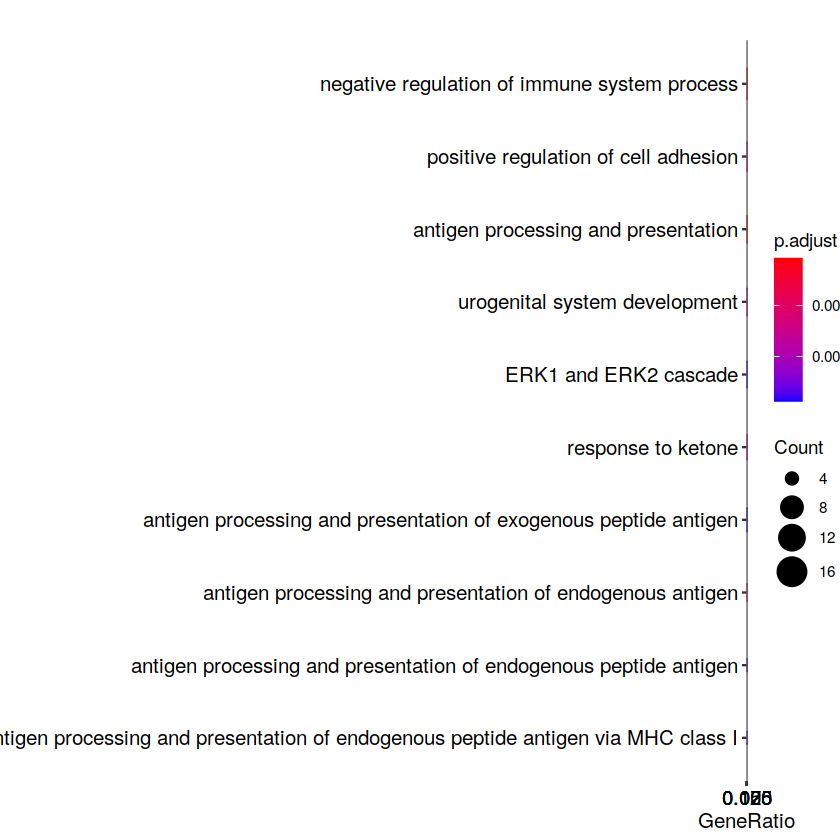

In [623]:
dotplot(down_enrichGO_result_adeno)

# FigureS7C ratio comparison between normal and tumor

In [78]:
fibroblast_ratio = fibroblast_ratio_all[fibroblast_ratio_all$histological.type.short %in% c("CC","XGC","LG","HG","adeno"),]
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"sample.type")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("sample.type","variable","Freq")

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using sample.type as id variables



In [80]:
data_plot_melt$Freq = data_plot_melt$Freq*100

In [30]:
pdf("./figures/tumor_normal_compare0810.pdf",height = 4,width = 3.5)
for(itype in high_entropy_cluster){
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "sample.type", y = "Freq",
               color = "sample.type", palette = "jco",add = "jitter")
   print(p + stat_compare_means(label = "p.signif",comparisons = list(c("Normal","Tumor"))) +ggtitle(itype)+ylab("Percentage"))
}
dev.off()

png 
  2

In [85]:
high_entropy_cluster = c('F_C0_MMP11','F_C1_CFD','F_C2_COLEC11','Per_C0_RGS5','Per_C1_MYH11','Per_C3_STEAP4')

In [108]:
pdf("./figures/tumor_normal_compare0905.pdf",height = 4,width = 2)
for(itype in high_entropy_cluster){
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "sample.type", y = "Freq",
               color = "sample.type", palette = "jco",add = "jitter")
   print(p + stat_compare_means(comparisons = list(c("Normal","Tumor"))) +ggtitle(itype)+ylab("Percentage"))+theme(axis.title.x = element_blank()) +
    theme(axis.text.x = element_blank())  
}
dev.off()

png 
  2

In [109]:
ggplot_list = list()
cluster_plot = c("F_C0_MMP11","Per_C0_RGS5","Per_C3_STEAP4")
for(itype in cluster_plot){
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "sample.type", y = "Freq",
               color = "sample.type", palette = "jco",add = "jitter")
   ggplot_list[[itype]] = p + stat_compare_means(comparisons = list(c("Normal","Tumor")))+ylab(itype)+theme(axis.title.x = element_blank()) +
    theme(axis.text.x = element_blank())  
}


In [110]:
library("patchwork")
library(RColorBrewer)

In [111]:
pdf("./figures/tumor_normal_compare_combined.pdf",height = 3,width = 6)
ggplot_list[[1]]+ggplot_list[[2]]+ggplot_list[[3]] + plot_layout(guides = 'collect') & theme(legend.position = c("top"))
dev.off()

png 
  2

In [169]:
for(itype in high_entropy_cluster){
   pdf(paste0("./figures/normal_tumor_compare/",itype,".pdf"),height = 4,width = 3.5)
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "sample.type", y = "Freq",
               color = "sample.type", palette = "jco",add = "jitter")
   print(p + stat_compare_means(label = "p.signif",comparisons = list(c("Normal","Tumor"))) +ggtitle(itype)+ylab("Percentage"))
   dev.off()
}


# figure S7D ratio comparison between P_metas and P

In [1245]:
fibroblast_ratio = fibroblast_ratio_all
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$Tumors.for.scRNA.seq.short=="P",]
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$histological.type.short %in% "adeno",]

In [1246]:
fibroblast_ratio$metastasis.type = as.character(fibroblast_ratio$metastasis.type)

In [1247]:
fibroblast_ratio$metastasis.type[fibroblast_ratio$metastasis.type %in% c("P_LN","P_LM")] = "P_Metas"

In [1248]:
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"metastasis.type")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using metastasis.type as id variables



In [119]:
ggplot_list = list()
cluster_plot = c("F_C1_CFD","Per_C1_MYH11","Per_C3_STEAP4")
for(itype in cluster_plot){
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "metastasis.type", y = "Freq",
               color = "metastasis.type", palette = "jco",add = "jitter")
   ggplot_list[[itype]] = p + stat_compare_means(comparisons = list(c("P","P_Metas")))+ylab(itype)+theme(axis.title.x = element_blank()) +
    theme(axis.text.x = element_blank())  
}


In [120]:
library("patchwork")
library(RColorBrewer)

In [122]:
pdf("./figures/group_copare_metastasistype.pdf",height = 3,width = 6)
ggplot_list[[1]]+ggplot_list[[2]]+ggplot_list[[3]] + plot_layout(guides = 'collect') & theme(legend.position = c("top"))
dev.off()

png 
  2

In [63]:
pdf("./group_compare/group_compare_metastasistype.0816.pdf",width = 15,height = 5)
print(ggplot(data_plot_melt, aes( y=Freq, x=metastasis.type)) + geom_boxplot()+facet_grid(. ~variable)+
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
         axis.text.y = element_text(color="black"),
         axis.title=element_text())+ggtitle("")+
           stat_compare_means(comparisons = list(
   c("P","P_Metas")
  ),method = "wilcox.test",label="p.signif"))
dev.off()

png 
  2

In [47]:
cluster_num = 16

In [245]:
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"metastasis.type")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

pdf("/home/wyh/scdata/combined_data//fibroblast/group_compare/fibroblast_metastasis.type1129.pdf",width = 20,height = 10)
print(ggplot(data_plot_melt, aes( y=Freq, x=metastasis.type)) + geom_boxplot()+facet_grid(. ~variable)+
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
         axis.text.y = element_text(color="black"),
         axis.title=element_text())+ggtitle("")+
           stat_compare_means(comparisons = list(
   c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
  ),method = "wilcox.test",label="p.signif"))
dev.off()

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using metastasis.type as id variables

Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847019, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847

png 
  2

In [34]:
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"metastasis.type")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

pdf("/home/wyh/scdata/combined_data//fibroblast/group_compare/fibroblast_metastasis.type0810.pdf",width = 20,height = 10)
print(ggplot(data_plot_melt, aes( y=Freq, x=metastasis.type)) + geom_boxplot()+facet_grid(. ~variable)+
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
         axis.text.y = element_text(color="black"),
         axis.title=element_text())+ggtitle("")+
           stat_compare_means(comparisons = list(
   c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
  ),method = "wilcox.test"))
dev.off()

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using metastasis.type as id variables

Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847019, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847

png 
  2

In [117]:
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"progression.type.short")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("progression.type.short","variable","Freq")

pdf("/home/wyh/scdata/combined_data//fibroblast/group_compare/fibroblast_progression.type.pdf",width = 20,height = 10)
print(ggplot(data_plot_melt, aes( y=Freq, x=progression.type.short)) + geom_boxplot()+facet_grid(. ~variable)+
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
         axis.text.y = element_text(color="black"),
         axis.title=element_text())+ggtitle("")+
                  stat_compare_means(comparisons = list(
    c("Inflam","Proli"),c("Inflam","Mix"),c("Inflam","None"),
    c("Proli","Mix"),c("Proli","None")
  ),label="p.signif"))
dev.off()

Using progression.type.short as id variables

Warning message in wilcox.test.default(c(0.616541353383459, 0.422798552472859, 0.00803212851405622, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.616541353383459, 0.422798552472859, 0.00803212851405622, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.616541353383459, 0.422798552472859, 0.00803212851405622, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0145631067961165, 0.22020725388601, 0.479115479115479, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0145631067961165, 0.22020725388601, 0.479115479115479, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0.00422195416164053, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0.00422195416164053, :
“cannot compute exact p-value with

png 
  2

In [ ]:
 fibroblast_ratio = fibroblast_ratio_all[fibroblast_ratio_all$Tumors.for.scRNA.seq.short=="P",]
    fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$histological.type.short %in% "adeno",]
    data_plot = fibroblast_ratio[,c(paste0("score_GM",1),"metastasis.type")]
    data_plot_melt = reshape2::melt(data_plot)
    colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

    pdf(paste0("/home/wyh/scdata/combined_data//fibroblast/figures/adeno_epithelial_metastasis_icaf.pdf"),width = 30,height = 5)
    print(ggplot(data_plot_melt, aes( y=Freq, x=metastasis.type)) + geom_boxplot()+facet_grid(. ~variable)+
        theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
             axis.text.y = element_text(color="black"),
             axis.title=element_text())+ggtitle("")+
          stat_compare_means(comparisons = list(
       c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
      ),method = "wilcox.test",label="p.signif"))
    dev.off()

In [35]:
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[1:cluster_num],"metastasis.type")]
data_plot_melt = melt(data_plot)
colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

Warning message in melt(data_plot):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_plot). In the next version, this warning will become an error.”
Using metastasis.type as id variables



In [36]:
data_plot_melt$Freq = data_plot_melt$Freq*100

In [174]:
for(itype in high_entropy_cluster){
   pdf(paste0("./figures/metastasis.type.compare/",itype,".pdf"),height = 4,width = 3.5)
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "metastasis.type", y = "Freq",
               color = "metastasis.type", palette = "jco",add = "jitter")
   print(p + stat_compare_means(comparisons = list(
       c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
      ),method = "wilcox.test",label="p.signif")+ggtitle(itype)+ylab("Percentage"))
   dev.off()
}

Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.616541353383459, 0.392070484581498, 0.00583941605839416, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847019, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0676691729323308, 0, 0, 0.0326209223847019, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.179611650485437, 0.126943005181347, 0.0481927710843374, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0.110132158590308, 0.0686131386861314, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.383495145631068, 0.194300518134715, 0.610441767068273, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.04

In [38]:
data_plot_melt$metastasis.type2 = as.character(data_plot_melt$metastasis.type)

In [39]:
data_plot_melt$metastasis.type2[data_plot_melt$metastasis.type2 %in% c("P_LN","P_LM")] = "P_Mets"

In [193]:
for(itype in high_entropy_cluster){
   pdf(paste0("./figures/metastasis.type.compare2/",itype,".pdf"),height = 4,width = 3.5)
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "metastasis.type2", y = "Freq",
               color = "metastasis.type2", palette = "jco",add = "jitter")
   print(p + stat_compare_means(comparisons = list(
       c("P","P_Mets")
      ),method = "wilcox.test",label="p.signif")+ggtitle(itype)+ylab("Percentage"))
   dev.off()
}

In [41]:
for(itype in high_entropy_cluster){
   pdf(paste0("./figures/metastasis.type.compare2/",itype,"0810.pdf"),height = 4,width = 3.5)
   p <- ggboxplot(data_plot_melt[data_plot_melt$variable==itype,], x = "metastasis.type2", y = "Freq",
               color = "metastasis.type2", palette = "jco",add = "jitter")
   print(p + stat_compare_means(comparisons = list(
       c("P","P_Mets")
      ),method = "wilcox.test")+ggtitle(itype)+ylab("Percentage"))
   dev.off()
}

# survival 

In [119]:
library(dplyr)
library(survminer)
library(survival)

In [120]:
survival_info = read.csv("/home/wyh/scdata/patient_info/survival/survival_0411.csv",row.names = 1)
head(survival_info)

,Sample.ID,NewSample.ID,Tumors.for.scRNA.seq,Sex,Age,TNM,Clinical.stage,histological.type,Differentiation,CA.19.9..U.ml.,⋯,histological.type.short,patient.index,Tumors.for.scRNA.seq.short,metastasis.type,progression.type,progression.type.short,DFS_month,OS_month,event,patient_index
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>
GBC_001_LI,GBC1,GBC_001_LI,liver invasion,M,67,T4NxM1,IVB,adenocarcinoma,Moderate,>1000,⋯,adeno,237090,LI,NA,Inflammatory,Inflam,NA,6.0,dead,237090
GBC_002_P,GBC2,GBC_002_P,Primary,F,85,T2bN0M0,IIB,adenocarcinoma,Moderate,Negative,⋯,adeno,365687,P,P,Inflammatory,Inflam,11.8,11.8,norecurrence,365687
GBC_003_P,GBC3,GBC_003_P,Primary,F,71,T4NxM0,IVA,adenocarcinoma,Moderate,57.38,⋯,adeno,365672,P,P_LN,Proliferative,Proli,NA,5.0,dead,365672
GBC_004_P,GBC4,GBC_004_P,Primary,M,71,T3N1M1,IVB,adenocarcinoma,Poor,386,⋯,adeno,237543,P,P_LM,Inflammatory,Inflam,11.6,11.6,norecurrence,237543
GBC_005_P,GBC5,GBC_005_P,Primary,M,68,T4NxM0,IVA,adenosquamous carcinoma,Poor,Negative,⋯,adeno squa,237456,P,P_LN,Inflammatory,Inflam,1.6,3.5,dead,237456
GBC_006_P,GBC6,GBC_006_P,Primary,M,59,T4N1M0,IVA,adenocarcinoma,Moderate,61.09,⋯,adeno,365681,P,P_LN,Proliferative,Proli,NA,8.4,dead,365681


In [232]:
#
fibroblast_ratio = fibroblast_ratio_all
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$Tumors.for.scRNA.seq.short=="P",]
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$histological.type.short %in% "adeno",]


common_patient = intersect(rownames(fibroblast_ratio),rownames(survival_info))
fibroblast_ratio = left_join(fibroblast_ratio[common_patient,],survival_info[common_patient,],by = "NewSample.ID")
rownames(fibroblast_ratio) = fibroblast_ratio$NewSample.ID
fibroblast_ratio$event01 = ifelse(fibroblast_ratio$event=="dead",1,0)
head(fibroblast_ratio)

,F_C0_MMP11,F_C1_CFD,F_C10_ACTG2,F_C11_APOD,F_C2_COLEC11,F_C3_IGFBP2,F_C4_CCN5,F_C5_KRT19,F_C6_MMP1,F_C7_COL4A2,⋯,patient.index.y,Tumors.for.scRNA.seq.short.y,metastasis.type.y,progression.type.y,progression.type.short.y,DFS_month,OS_month,event,patient_index,event01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>
GBC_002_P,0.616541353,0.067669173,0.000000000,0,0.000000000,0.007518797,0,0.000000000,0.011278195,0.003759398,⋯,365687,P,P,Inflammatory,Inflam,11.8,11.8,norecurrence,365687,0
GBC_003_P,0.014563107,0.179611650,0.009708738,0,0.383495146,0.000000000,0,0.004854369,0.000000000,0.014563107,⋯,365672,P,P_LN,Proliferative,Proli,NA,5.0,dead,365672,1
GBC_004_P,0.422798552,0.004221954,0.045838359,0,0.005428227,0.005428227,0,0.001809409,0.001809409,0.004221954,⋯,237543,P,P_LM,Inflammatory,Inflam,11.6,11.6,norecurrence,237543,0
GBC_006_P,0.220207254,0.126943005,0.002590674,0,0.194300518,0.010362694,0,0.005181347,0.010362694,0.012953368,⋯,365681,P,P_LN,Proliferative,Proli,NA,8.4,dead,365681,1
GBC_007_P,0.008032129,0.048192771,0.000000000,0,0.610441767,0.000000000,0,0.000000000,0.000000000,0.000000000,⋯,365614,P,P_LN,Inflammatory,Inflam,NA,11.4,dead,365614,1
GBC_008_P,0.392070485,0.000000000,0.004405286,0,0.110132159,0.008810573,0,0.008810573,0.000000000,0.008810573,⋯,366256,P,P,Mixture,Mix,11.1,11.1,norecurrence,366256,0


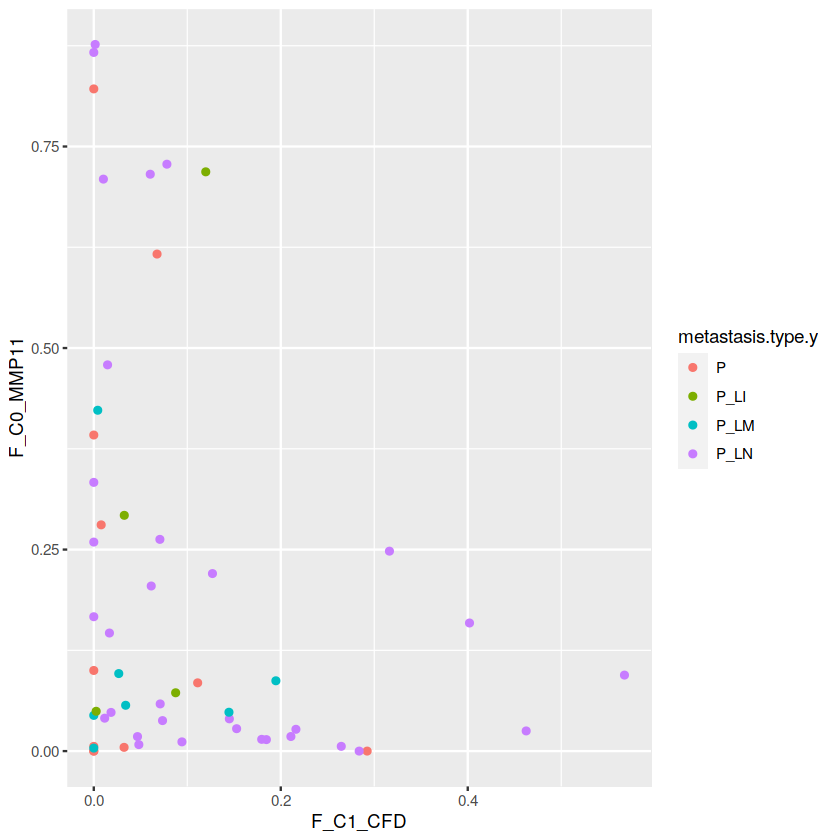

In [42]:
ggplot(fibroblast_ratio,aes(x = F_C1_CFD,y = F_C0_MMP11))+geom_point(aes(color = metastasis.type.y))

In [214]:
iCAF_median = median(fibroblast_ratio$F_C1_CFD)
iCAF_median

mCAF_median = median(fibroblast_ratio$F_C0_MMP11)
mCAF_median

[1] 0.05429516

[1] 0.07849556

In [215]:
fibroblast_ratio$group = "mCAF+iCAF+"
fibroblast_ratio$group[fibroblast_ratio$F_C0_MMP11>mCAF_median & fibroblast_ratio$F_C1_CFD<iCAF_median] = "mCAF+iCAF-"
fibroblast_ratio$group[fibroblast_ratio$F_C0_MMP11<mCAF_median & fibroblast_ratio$F_C1_CFD>iCAF_median] = "mCAF-iCAF+"
fibroblast_ratio$group[fibroblast_ratio$F_C0_MMP11<mCAF_median & fibroblast_ratio$F_C1_CFD<iCAF_median] = "mCAF-iCAF-"

In [218]:
dim(fibroblast_ratio)

[1] 54 92

In [216]:
fibroblast_ratio$group = "na"
fibroblast_ratio$group[fibroblast_ratio$F_C0_MMP11>=mCAF_median & fibroblast_ratio$F_C1_CFD>=iCAF_median] = "mCAF+iCAF+"
fibroblast_ratio$group[fibroblast_ratio$F_C0_MMP11>=mCAF_median & fibroblast_ratio$F_C1_CFD<iCAF_median] = "mCAF+iCAF-"
fibroblast_ratio$group[fibroblast_ratio$F_C0_MMP11<mCAF_median & fibroblast_ratio$F_C1_CFD>=iCAF_median] = "mCAF-iCAF+"
fibroblast_ratio$group[fibroblast_ratio$F_C0_MMP11<mCAF_median & fibroblast_ratio$F_C1_CFD<iCAF_median] = "mCAF-iCAF-"

In [217]:
table(fibroblast_ratio$group)


mCAF-iCAF- mCAF-iCAF+ mCAF+iCAF- mCAF+iCAF+ 
        12         15         15         12 

In [219]:
fit<-survfit(Surv(OS_month, event01)~group, data=fibroblast_ratio)

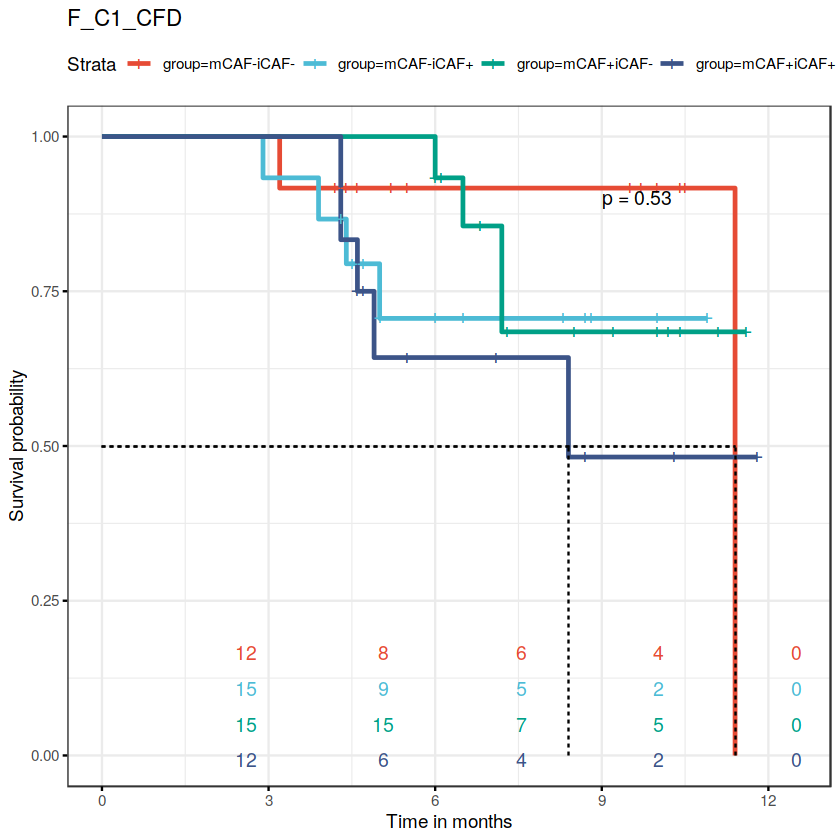

In [220]:
 p = ggsurvplot(
    fit,                     # survfit object with calculated statistics.
    data = fibroblast_ratio,             # data used to fit survival curves.
    risk.table = TRUE,       # show risk table.
    pval = TRUE,             # show p-value of log-rank test.
    #conf.int = TRUE,         # show confidence intervals for
    palette = "npg",
    xlab = "Time in months",   # customize X axis label.
    ggtheme = theme_bw(),
    #conf.int.style = "step",  # customize style of confidence intervals  "ribbon" 'step'
    surv.median.line = "hv",  # add the median survival pointer.
    # legend.labs = c("TP1", "TP2","TP3","TP4","TP5")    # change legend labels.
    tables.y.text = T,
    risk.table.pos = "in",
    risk.table.col = "strata",
    fontsize = 4,
    pval.size = 4,
    #surv.plot.height = 0.8,
    #tables.height = 0.2,
    pval.coord = c(9, 0.9),
    legend = "top",
    title = "F_C1_CFD"
  )
p

In [ ]:
## 单个分组的预后

In [29]:
pdf(paste0("./group_compare/survival0519_MMP11.pdf"),width = 10,height = 8)
for(itype in "MMP11"){
      fibroblast_ratio[paste0("Celltype","_Freq_group")] = ifelse(fibroblast_ratio[itype] > median(fibroblast_ratio[,itype]),'High','Low')
      fit<-survfit(Surv(OS_month, event01)~Celltype_Freq_group, data=fibroblast_ratio)
      print(ggsurvplot(fit, data = fibroblast_ratio, risk.table = TRUE, conf.int = FALSE,pval = TRUE,
           xlab="Time")+
  guides(
    fill = guide_legend(title = itype),
    color = guide_legend(title = itype)
  ))
}
dev.off()

ERROR: Error in `[.data.frame`(fibroblast_ratio, itype): undefined columns selected


In [301]:
getwd()

[1] "/home/wyh/scdata/combined_data/fibroblast"

In [197]:
pdf(paste0("./group_compare/survival0405.pdf"),width = 10,height = 8)
for(itype in setdiff(unique(celltype_info$subtype),c("C6.iCAFs.CFD","C10.mCAFs.MMP11"))){
      fibroblast_ratio[paste0("Celltype","_Freq_group")] = ifelse(fibroblast_ratio[itype] > median(fibroblast_ratio[,itype]),'High','Low')
      fit<-survfit(Surv(OS_month, event01)~Celltype_Freq_group, data=fibroblast_ratio)
      print(ggsurvplot(fit, data = fibroblast_ratio, risk.table = TRUE, conf.int = FALSE,pval = TRUE,
           xlab="Time")+
  guides(
    fill = guide_legend(title = itype),
    color = guide_legend(title = itype)
  ))
}
dev.off()

png 
  2

In [242]:
itype = "Per_C3_STEAP4"
fibroblast_ratio[paste0("Score")] = ifelse(fibroblast_ratio[itype] > median(fibroblast_ratio[,itype]),'High','Low')

In [243]:
fit<-survfit(Surv(OS_month, event01)~Score, data=fibroblast_ratio)
 

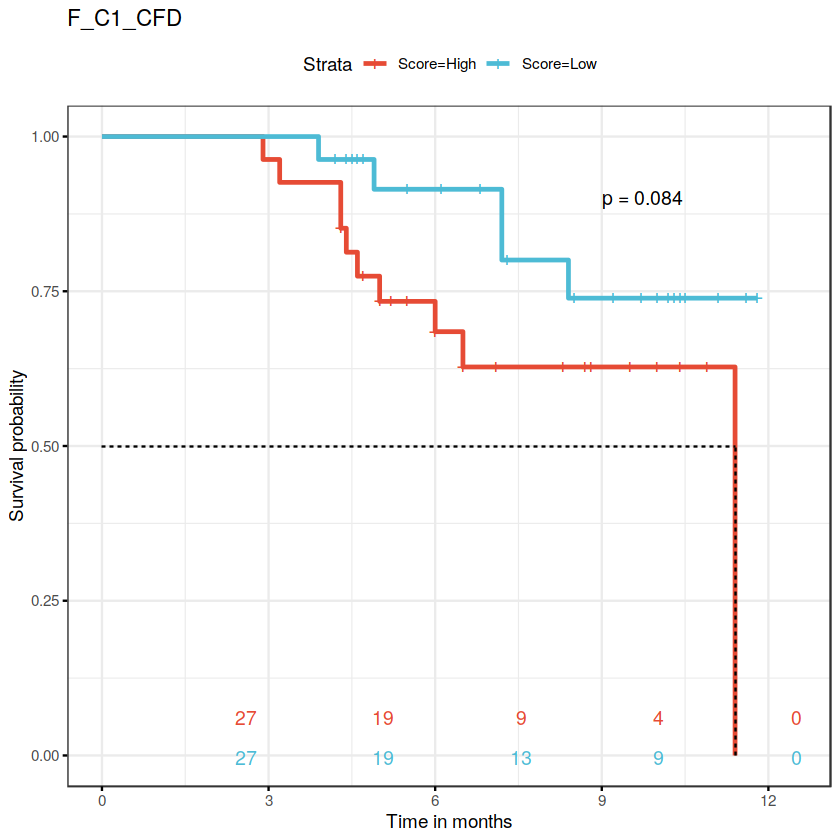

In [244]:
 p = ggsurvplot(
    fit,                     # survfit object with calculated statistics.
    data = fibroblast_ratio,             # data used to fit survival curves.
    risk.table = TRUE,       # show risk table.
    pval = TRUE,             # show p-value of log-rank test.
    #conf.int = TRUE,         # show confidence intervals for
    palette = "npg",
    xlab = "Time in months",   # customize X axis label.
    ggtheme = theme_bw(),
    #conf.int.style = "step",  # customize style of confidence intervals  "ribbon" 'step'
    surv.median.line = "hv",  # add the median survival pointer.
    # legend.labs = c("TP1", "TP2","TP3","TP4","TP5")    # change legend labels.
    tables.y.text = T,
    risk.table.pos = "in",
    risk.table.col = "strata",
    fontsize = 4,
    pval.size = 4,
    #surv.plot.height = 0.8,
    #tables.height = 0.2,
    pval.coord = c(9, 0.9),
    legend = "top",
    title = "F_C1_CFD"
  )
p

In [138]:
pdf("./figures/F_C1_CFD_survivalV2.pdf",height = 5,width = 4)
print(p,newpage = FALSE)
dev.off()

png 
  2

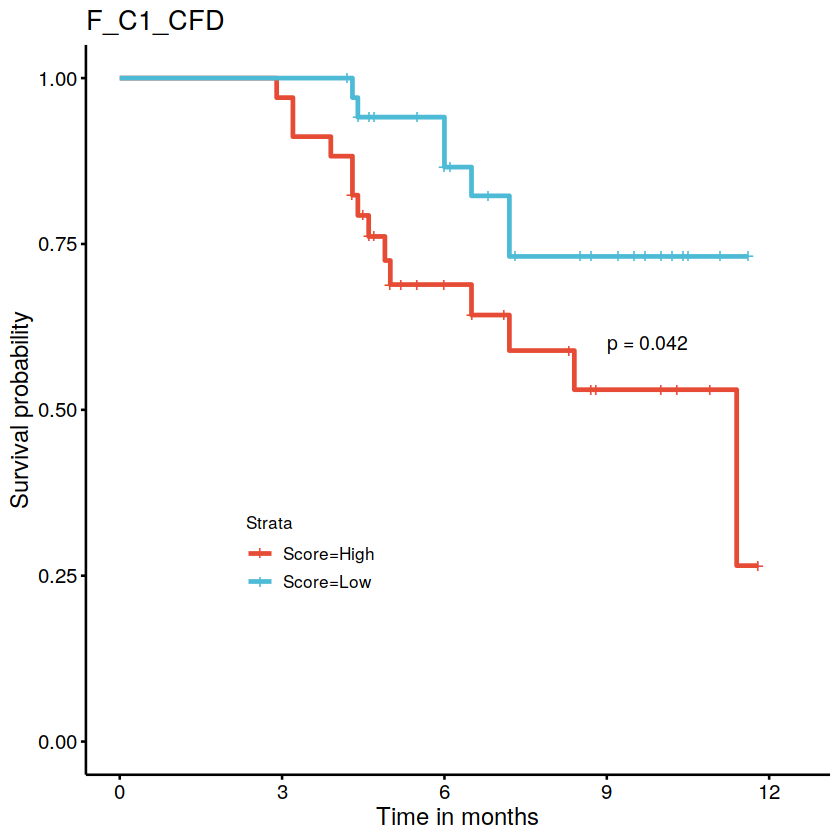

In [152]:
p = ggsurvplot(
    fit,                     # survfit object with calculated statistics.
    data = fibroblast_ratio,             # data used to fit survival curves.
    #risk.table = TRUE,       # show risk table.
    pval = TRUE,             # show p-value of log-rank test.
    #conf.int = TRUE,         # show confidence intervals for
    palette = "npg",
    xlab = "Time in months",   # customize X axis label.
    #ggtheme = theme_bw(),
    #conf.int.style = "step",  # customize style of confidence intervals  "ribbon" 'step'
    #surv.median.line = "hv",  # add the median survival pointer.
    # legend.labs = c("TP1", "TP2","TP3","TP4","TP5")    # change legend labels.
    tables.y.text = T,
    risk.table.pos = "in",
    risk.table.col = "strata",
    fontsize = 4,
    pval.size = 4,
    #surv.plot.height = 0.8,
    #tables.height = 0.2,
    pval.coord = c(9, 0.6),
    legend = c(0.3,0.3),
    # legend = "top",
    title = "F_C1_CFD"
  )
p

In [153]:
pdf("./figures/OS_survival_F_C1_CFD.pdf",height = 3.5,width = 3.5)
print(p,newpage = FALSE)
dev.off()

png 
  2

In [257]:
pdf(paste0("./group_compare/survival1129.pdf"),width = 10,height = 8)
for(itype in unique(celltype_info$subtype)){
      fibroblast_ratio[paste0("Celltype","_Freq_group")] = ifelse(fibroblast_ratio[itype] > median(fibroblast_ratio[,itype]),'High','Low')
      fit<-survfit(Surv(OS_month, event01)~Celltype_Freq_group, data=fibroblast_ratio)
      print(ggsurvplot(fit, data = fibroblast_ratio, risk.table = TRUE, conf.int = FALSE,pval = TRUE,
           xlab="Time")+
  guides(
    fill = guide_legend(title = itype),
    color = guide_legend(title = itype)
  ))
}
dev.off()

png 
  2

[1] "F_C7_KRT19."   "F_C2_RGS5."    "F_C0_MMP11."   "F_C15_STEAP4."
 [5] "F_C6_CCN5."    "F_C1_CFD."     "F_C13_APOD."   "F_C4_MYH11."  
 [9] "F_C3_COLEC11." "F_C11_S100B."  "F_C8_MMP1."    "F_C12_ACTG2."

In [308]:
pdf(paste0("./group_compare/survivalV3.pdf"),width = 10,height = 8)
for(itype in celltype_name){
      fibroblast_ratio[paste0("Celltype","_Freq_group")] = ifelse(fibroblast_ratio[itype] > median(fibroblast_ratio[,itype]),'High','Low')
      fit<-survfit(Surv(OS_month, event01)~Celltype_Freq_group, data=fibroblast_ratio)
      print(ggsurvplot(fit, data = fibroblast_ratio, risk.table = TRUE, conf.int = FALSE,pval = TRUE,
           xlab="Time")+
  guides(
    fill = guide_legend(title = itype),
    color = guide_legend(title = itype)
  ))
}
dev.off()

png 
  2

In [173]:
# 最佳cutofff
res.cut <- surv_cutpoint(fibroblast_ratio, time = "OS_month", event = "event01",
                         variables = setdiff(unique(celltype_info$subtype),c("C6.iCAFs.CFD","C10.mCAFs.MMP11")))
res.cat <- surv_categorize(res.cut)
pdf(paste0("./group_compare/survival_maximum_cutoff.pdf"),width = 10,height = 8)
for(itype in setdiff(unique(celltype_info$subtype),c("C6.iCAFs.CFD","C10.mCAFs.MMP11"))){
      res.cat['Celltype_Freq_group'] = res.cat[itype]
      fit<-survfit(Surv(OS_month, event01)~Celltype_Freq_group, data=res.cat)
      print(ggsurvplot(fit, data = res.cat, risk.table = TRUE, conf.int = FALSE,pval = TRUE,
           xlab="Time")+
  guides(
    fill = guide_legend(title = itype),
    color = guide_legend(title = itype)
  ))
}
dev.off()

  |======================================================================| 100%

png 
  2

In [164]:
res.cut <- surv_cutpoint(fibroblast_ratio, time = "OS_month", event = "event01",
                         variables = setdiff(unique(celltype_info$subtype),c("C6.iCAFs.CFD","C10.mCAFs.MMP11")))
summary(res.cut)

  |======================================================================| 100%

,cutpoint,statistic
,<dbl>,<dbl>
C7.eCAFs.KRT19,0.004854369,1.1015678
C2.vCAFs.RGS5,0.041176471,1.1397867
C0.mCAFs.MMP11,0.005882353,1.9272062
C5.iCAFs.IGFBP2,0.004016064,0.8132162
C15.apCAFs.STEAP4,0.015290520,1.8935206
C1.iCAFs.CFD,0.011661808,2.2206360
C13.iCAFs.TAC1,0.005813953,0.5908746
C14.apCAFs.VCAN,0.075129534,1.9753241
C4.vCAFs.WYH11,0.014760148,1.5087130


In [165]:
res.cat <- surv_categorize(res.cut) #命名的问题
head(res.cat)

,OS_month,event01,C7.eCAFs.KRT19,C2.vCAFs.RGS5,C0.mCAFs.MMP11,C5.iCAFs.IGFBP2,C15.apCAFs.STEAP4,C1.iCAFs.CFD,C13.iCAFs.TAC1,C14.apCAFs.VCAN,C4.vCAFs.WYH11,C3.mCAFs.PDGFRA,C9.mCAFs.COL4A2,C11.synovial.fibroblasts.S100B,C8.mCAFs.MMP1,C12.ACTG2
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GBC_002_P,11.8,0,low,high,high,high,low,high,low,low,high,low,low,low,high,low
GBC_003_P,5.0,1,low,high,high,low,high,high,low,low,high,low,low,low,low,high
GBC_004_P,11.6,0,low,low,high,high,low,low,low,high,high,low,low,low,high,high
GBC_006_P,8.4,1,high,high,high,high,high,high,low,low,high,low,low,low,high,high
GBC_007_P,11.4,1,low,high,high,low,high,high,low,low,high,high,low,low,low,low
GBC_008_P,11.1,0,high,high,high,high,low,low,low,high,high,low,low,low,low,high


In [166]:
res.cat <- surv_categorize(res.cut)

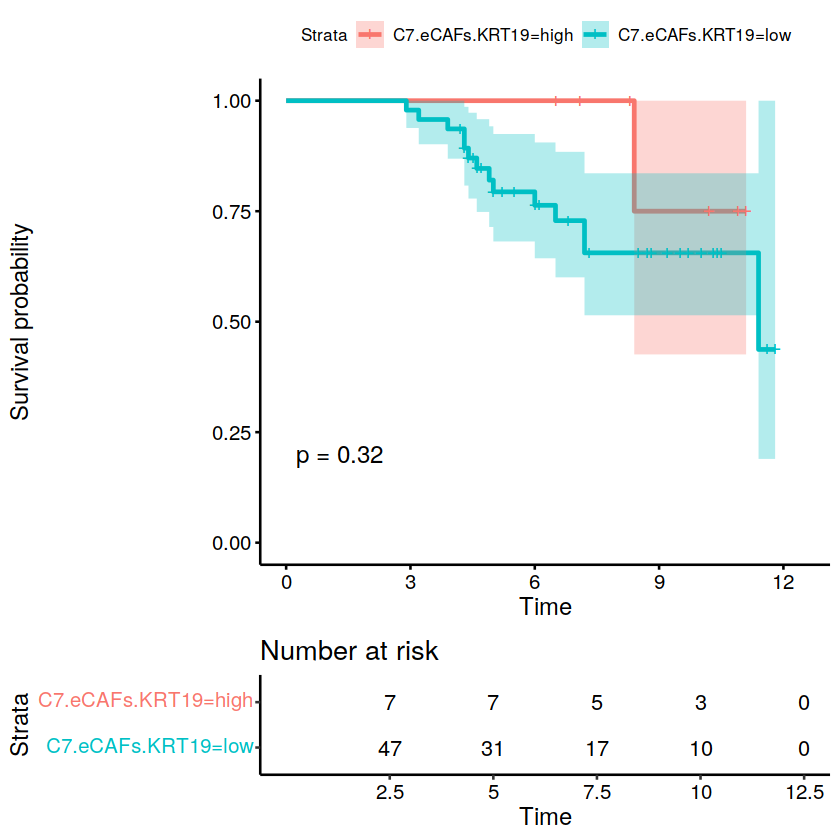

In [167]:
fit <- survfit(Surv(OS_month, event01) ~C7.eCAFs.KRT19, data = res.cat)
ggsurvplot(fit, data = res.cat, risk.table = TRUE, conf.int = TRUE,pval = TRUE)